In [1]:
# 라이브러리 임포트
import pandas as pd
import numpy as np
import graphviz
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import scipy.stats as stats
import warnings

from statsmodels.formula.api import ols
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.tree import export_graphviz
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import qqplot, add_constant
from sklearn.metrics import r2_score
from statsmodels.api import qqplot, add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import ols
import statsmodels.api as sm


%matplotlib inline
warnings.filterwarnings('ignore')
import platform
plt.rcParams['font.family'] = 'NanumGothic' 
matplotlib.rcParams['axes.unicode_minus'] = False

In [2]:
# Power 기준 차량 크기 구분하는 함수
# 경차 -> 1000 미만
# 소형 -> 1600 미만
# 중형 -> 2000 미만
# 대형 -> 2000 이상
def car_size(cc):
    if cc >= 2000:
        car_size = 'full'
    elif cc >= 1600:
        car_size = 'mid'
    elif cc > 1000:
        car_size = 'small'
    else:
        car_size = 'light'
        
    return car_size

In [3]:
# Name열 split 후 회사명(브랜드)만 리턴하는 함수
def extract_brand(text):
    return text.split()[0]

# 전체 과정
1. 도메인 정보 파악
2. 전처리
3. EDA
4. 모델링
5. 핵심 인자 도출
6. 경쟁력 확보 방안 도출

# 1. 도메인 정보 파악 - pass
- 배경 : 인도 중고차 시장의 성장 -> 중고차 가격을 효과적으로 예측할 수 있는 핵심영향인자 도출 + 가격 예측 모델 개발
- 기본 가정 : 인도 중고차 시장은 가성비 좋은 차량을 선호한다.
    1) (Engine) 엔진 배기량이 높을수록 자동차 성능이 좋다(상대적으로 큰 차량이다) -> 가격이 높다.
    2) (Power) 엔진 출력이 높을수록 자동차 성능이 좋다 -> 가격이 높다.
    3) (Mileage) 연비가 높을수록 자동차 성능이 좋다 -> 가격이 높다.
    4) (Kilometers_Driven) 주행거리가 낮을 수록 자동차 성능이 좋다 -> 가격이 높다.
    5) (Year) 출고년도가 높을 수록(최신이다) 자동차 성능이 좋다 -> 가격이 높다.
    6) (Seats) 좌석수가 많을 수록 자동차 성능이 좋다(큰 차량이다) -> 가격이 높다.
    7) (Owner_Type) 첫번째 중고차일수록 자동차 성능이 좋다 -> 가격이 높다.
- 도메인 지식을 활용한 추가 가정
    1) (Transmission) 인도는 도로 상황이 좋지 않고, 가격이 저렴한 수동 차량을 선호한다. 수동 차량이 가격이 낮다.
    2) (Location) Delhi, Mumbai, Chennai, Kolkata, Hyderabad 5개 도시는 인프라, 수요 조건(인구, 소득 조건), 기업 경쟁력(다양성)을 기준으로 조사를 해보았을 때 인도에서 잘사는 도시로 판단된다. 따라서 상대적으로 가격이 비싼 차량이 많이 팔릴 것으로 예상된다.
    3) (Brand) 브랜드는 가성비가 좋은 인도 회사인 Maruti가 전체적으로 가장 많이 선호될 것으로 예상된다.
    4) (Fuel_Type) 연비가 좋은 디젤(경유), 패트롤(가솔린) 차량이 선호될 것으로 예상된다.

# 2. 데이터 전처리
1) 데이터 불러오기 / 요약정보 파악
2) 결측치 처리
3) 이상치 처리
4) 컬럼 특성 파악 및 전처리
    - Name
    - Location
    - Price
    - Year
    - Kilometers_driven
    - Fuel_Type
    - Owner_Type
    - Mileage
    - Engine
    - Power
    - Seats

In [4]:
# 1) 데이터 불러오기
df = pd.read_csv('Car.csv')
df.head()

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price
0,Maruti Wagon R LXI CNG,Mumbai,2682.68,2010,72000,CNG,Manual,First,26.6 kmpl,998 CC,58.16 bhp,5.0,NaN
1,Hyundai Creta 1.6 CRDi SX Option,Pune,19162.00,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN
2,Honda Jazz V,Chennai,6898.32,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh
3,Maruti Ertiga VDI,Chennai,9197.76,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,27194.71,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN


In [5]:
# 요약정보
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7253 entries, 0 to 7252
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               7253 non-null   object 
 1   Location           7253 non-null   object 
 2   Price              6200 non-null   float64
 3   Year               7253 non-null   int64  
 4   Kilometers_Driven  7253 non-null   int64  
 5   Fuel_Type          7253 non-null   object 
 6   Transmission       7253 non-null   object 
 7   Owner_Type         7253 non-null   object 
 8   Mileage            7251 non-null   object 
 9   Engine             7207 non-null   object 
 10  Power              7207 non-null   object 
 11  Seats              7200 non-null   float64
 12  New_Price          1006 non-null   object 
dtypes: float64(2), int64(2), object(9)
memory usage: 736.8+ KB


### 데이터 설명
* 목표변수
    - Price 중고차 가격(단위 : 1,000원)
* 설명변수
   - Name : 자동차 브랜드와 모델의 이름
   - Location : 자동차를 팔거나 구매할 수 있는 위치
   - Year : 모델의 년도 혹은 버전
   - Kilometers_Driven : 이전 소유주의 차량 주행거리(Km)
   - Fuel_Type : 자동차의 사용연료의 종류
   - Transmission : 자동차의 사용 변속기 종류(Manual/Automatic)
   - Owner_Type : 소유권이 직접 소유인지, 중고 소유인지 여부
   - Mileage : 자동차 회사가 제공하는 표준주행거리(kmpl)
   - Engine : 엔진의 배기량(cc)
   - Power : 엔진의 최대 출력(bhp)
   - Seats : 차의 좌석 수
   - New_Price : 뉴 모델의 가격

In [6]:
df.describe() # 수치형 변수 기술통계량

,Price,Year,Kilometers_Driven,Seats
count,6200.000000,7253.000000,7.253000e+03,7200.000000
mean,14912.514750,2013.365366,5.869906e+04,5.279722
std,17674.318464,3.254421,8.442772e+04,0.811660
min,7.080000,1996.000000,1.710000e+02,0.000000
25%,5365.360000,2011.000000,3.400000e+04,5.000000
50%,8814.520000,2014.000000,5.341600e+04,5.000000
75%,15869.972500,2016.000000,7.300000e+04,5.000000
max,245273.600000,2019.000000,6.500000e+06,10.000000


### 결측치

In [7]:
# 결측치 확인
df.isnull().sum()

Name                    0
Location                0
Price                1053
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 46
Power                  46
Seats                  53
New_Price            6247
dtype: int64

- New_Price : 결측치가 6247개로 전체 7253개 중 약 86.1%로 큰 비중을 차지하고, 열 특성 자체가 가격 예측에 영향을 주지 않을 것이라 판단되어 열 자체 제거
- Mileage, Engine, Power, Seats : 결측치의 개수가 적어 결측치가 예측에 큰 영향을 주지 않을 것이라 판단되어 결측치에 해당하는 행만 제거
- Price : 1053개의 결측치가 존재하지만, 목표변수에 해당하므로 따로 보간하지 않고 결측치 존재 행 제거

In [8]:
# Price 결측치 제거
df.dropna(subset=['Price'], inplace=True)
df[df['Price'].isna()]

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price


In [9]:
# New_Price 컬럼 제거
df.drop('New_Price',axis=1,inplace=True)

In [10]:
# Mileage / Engine / Power / Seats 결측치 제거
df.dropna(subset=['Mileage','Engine','Power','Seats'],axis=0,inplace=True)

### 이상치

In [11]:
# Power 열 null bhp 제거
# 수치상 null은 이상치로 판단하고 제거
df[df['Power'] == 'null bhp'] 
df = df[df['Power'] != 'null bhp'] # 제거

<Axes: >

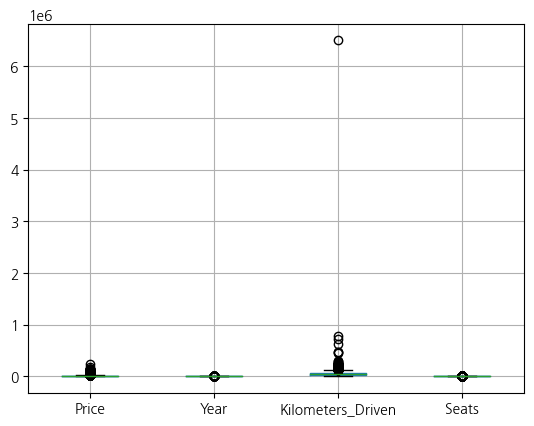

In [12]:
df.boxplot()

- Kilometers_Driven에서 이상치로 판단되는 값이 하나 확인됨.
- 이외에 아직 이상치 판단하기 어려움이 있어 데이터 파악 후 추후 처리 진행 예정.

### 단위제거 및 형변환
- 단위 들어가 있는 컬럼 단위 제거 후 수치형으로 변환
- ex. Mileage : 17.8 kmpl -> 17.8

In [13]:
df['Mileage'] = df['Mileage'].str.replace('kmpl','').astype('float')
df['Engine'] = df['Engine'].str.replace('CC','').astype('float')
df['Power'] = df['Power'].str.replace('bhp','').astype('float')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6053 entries, 0 to 7236
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6053 non-null   object 
 1   Location           6053 non-null   object 
 2   Price              6053 non-null   float64
 3   Year               6053 non-null   int64  
 4   Kilometers_Driven  6053 non-null   int64  
 5   Fuel_Type          6053 non-null   object 
 6   Transmission       6053 non-null   object 
 7   Owner_Type         6053 non-null   object 
 8   Mileage            6053 non-null   float64
 9   Engine             6053 non-null   float64
 10  Power              6053 non-null   float64
 11  Seats              6053 non-null   float64
dtypes: float64(5), int64(2), object(5)
memory usage: 614.8+ KB


### 파생변수 생성

In [15]:
df.Name.nunique()
# Name의 unique의 개수가 너무 많아 분석 및 판단에 이상이 있을 것이라 생각됨.
# Name에서 Brand명만 구분하여 사용하는 Brand 파생변수 생성

1856

In [16]:
df['Brand'] = df['Name'].apply(extract_brand)
df['Brand'].head()

0     Maruti
1    Hyundai
2      Honda
3     Maruti
4       Audi
Name: Brand, dtype: object

In [17]:
# Name 변수 제거
df.drop('Name',axis=1,inplace=True)

In [18]:
df['Brand'].value_counts()

Maruti           1218
Hyundai          1079
Honda             614
Toyota            406
Mercedes-Benz     323
Volkswagen        320
Ford              298
Mahindra          278
BMW               268
Audi              240
Tata              192
Skoda             181
Renault           151
Chevrolet         120
Nissan             93
Land               57
Jaguar             43
Mitsubishi         34
Mini               29
Fiat               26
Volvo              21
Jeep               19
Datsun             17
Porsche            16
ISUZU               3
Force               3
Bentley             2
Ambassador          1
Lamborghini         1
Name: Brand, dtype: int64

In [19]:
# Engine(배기량)을 기준으로 차량의 사이즈를 구분하는 Size 파생변수 생성
df['Size']= df['Engine'].apply(car_size)

In [20]:
df['Size'].head()

0    light
1    small
2    small
3    small
4      mid
Name: Size, dtype: object

Text(0.5, 1.0, 'Seats')

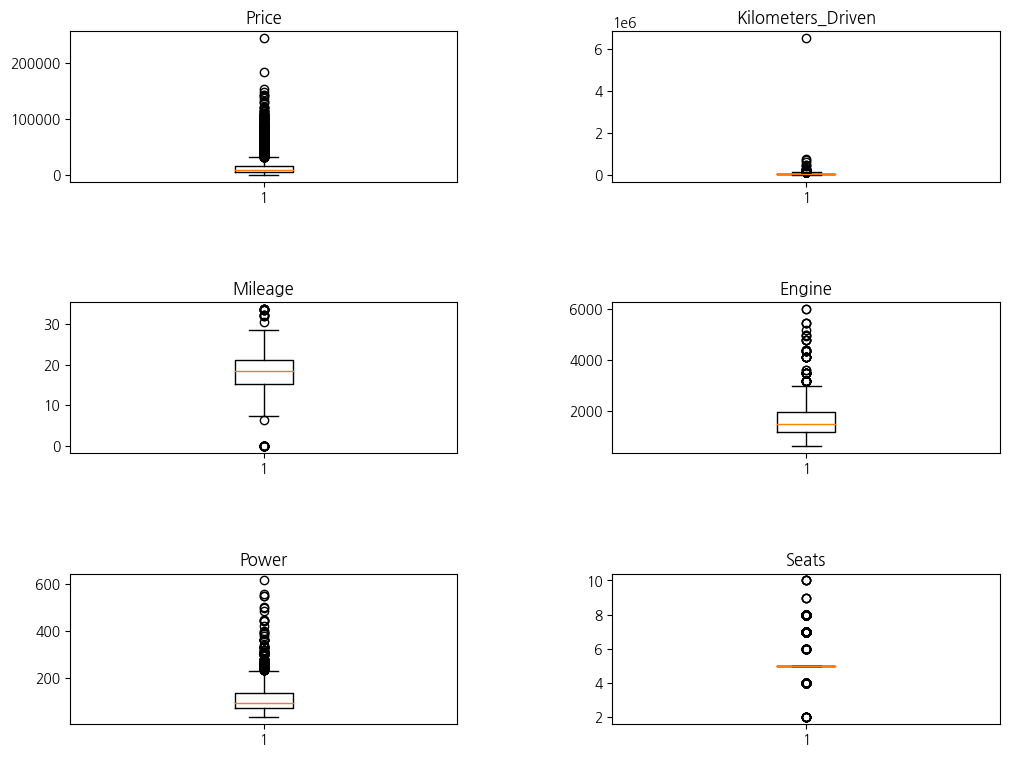

In [21]:
#이상치 재확인을 위한 box-plot
fig, axs = plt.subplots(3, 2, figsize=(12, 9))
axs = axs.flatten()

fig.subplots_adjust(wspace=0.4, hspace=0.8)

axs[0].boxplot(df['Price'])
axs[0].set_title('Price')

axs[1].boxplot(df['Kilometers_Driven'])
axs[1].set_title('Kilometers_Driven')

axs[2].boxplot(df['Mileage'])
axs[2].set_title('Mileage')

axs[3].boxplot(df['Engine'])
axs[3].set_title('Engine')

axs[4].boxplot(df['Power'])
axs[4].set_title('Power')

axs[5].boxplot(df['Seats'])
axs[5].set_title('Seats')

- Price, Power 열의 이상치가 많이 분포한다고 판단되어 따로 확인

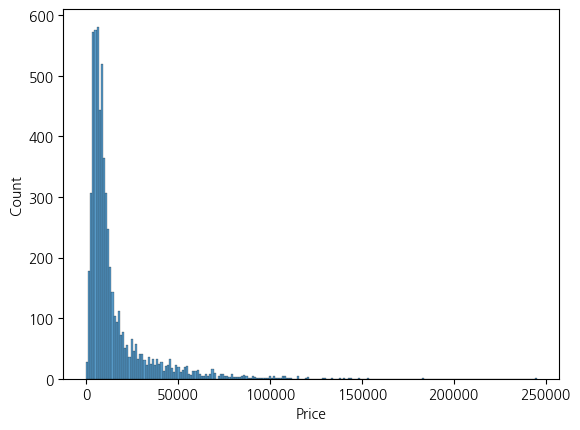

In [22]:
sns.histplot(df['Price'])
plt.show()

- 대부분이 50000 이하에 분포한다.
- 그래프가 정규성을 띄지 않는다 판단하여 정규분포를 띄도록 로그 변환 진행 후 새로운 파생 변수로 저장 + 기존 Price 컬럼 삭제

In [23]:
df['Price_log']=np.log(df['Price'])
df.drop("Price", axis=1, inplace=True)

<Axes: xlabel='Price_log', ylabel='Count'>

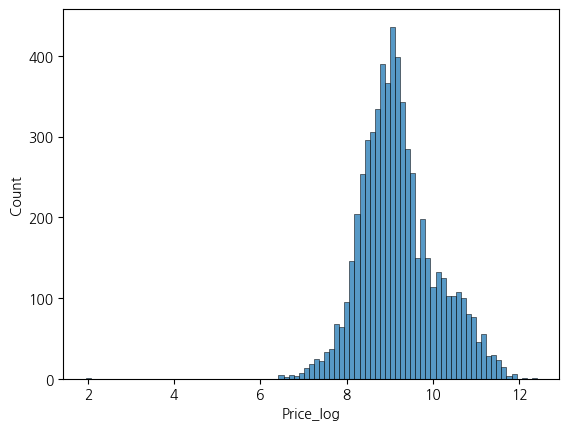

In [24]:
# 재확인
sns.histplot(df['Price_log'])

- 로그 변환을 통해 비대칭 분포를 보다 정규 분포의 형태에 가깝게 변형

<Axes: xlabel='Power', ylabel='Count'>

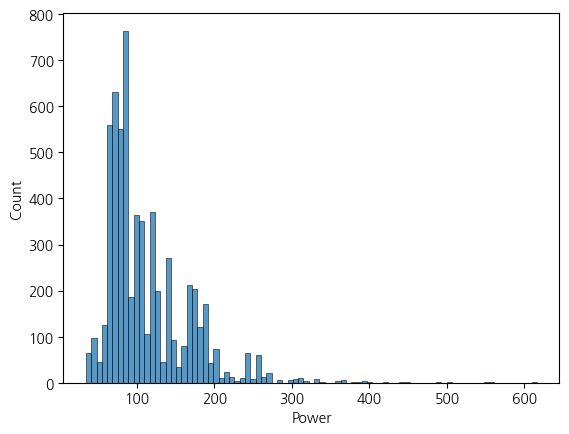

In [25]:
sns.histplot(df['Power'])

- 마찬가지로 정규분포의 형태로 띄게 하기 위해 로그 변환

In [26]:
df['Power_log']=np.log(df['Power'])
df.drop("Power", axis=1, inplace=True)

<Axes: xlabel='Power_log', ylabel='Count'>

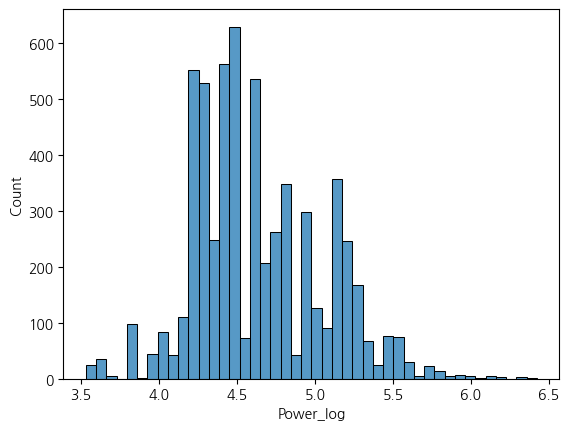

In [27]:
sns.histplot(df['Power_log'])

- 좀 더 정규분포에 가깝게 변형됨.

In [28]:
# 이상치 재확인
df.describe()

,Year,Kilometers_Driven,Mileage,Engine,Seats,Price_log,Power_log
count,6053.000000,6.053000e+03,6053.000000,6053.000000,6053.000000,6053.000000,6053.000000
mean,2013.551958,5.773449e+04,18.323215,1624.315876,5.283331,9.199538,4.638028
std,3.167314,9.096035e+04,4.365746,601.783463,0.804717,0.875582,0.416573
min,1998.000000,1.710000e+02,0.000000,624.000000,2.000000,1.957274,3.532226
25%,2012.000000,3.280700e+04,15.290000,1198.000000,5.000000,8.615890,4.317488
50%,2014.000000,5.200000e+04,18.480000,1495.000000,5.000000,9.092814,4.580877
75%,2016.000000,7.200000e+04,21.100000,1984.000000,5.000000,9.686331,4.927978
max,2019.000000,6.500000e+06,33.540000,5998.000000,10.000000,12.410130,6.423247


In [29]:
# Kilometers_Driven max 값이 약 650만 키로로 이상치로 판단됨 -> 제거
# 앞서 boxplot에서 한개로 파악되었으므로 바로 제거
df = df[df['Kilometers_Driven'] < 6500000]
df

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Seats,Brand,Size,Price_log,Power_log
0,Mumbai,2010,72000,CNG,Manual,First,26.60,998.0,5.0,Maruti,light,7.894572,4.063198
1,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,5.0,Hyundai,small,9.860684,4.837868
2,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,5.0,Honda,small,8.839033,4.485260
3,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,7.0,Maruti,small,9.126715,4.485936
4,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,5.0,Audi,mid,10.210778,4.947340
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7228,Pune,2016,41413,Diesel,Manual,First,27.28,1047.0,5.0,Tata,small,9.289401,4.234107
7231,Kochi,2017,39015,Petrol,Manual,First,17.00,1497.0,5.0,Ford,small,9.508571,4.798761
7232,Mumbai,2018,6000,Petrol,Manual,First,16.00,1368.0,5.0,Jeep,small,10.234177,5.075174
7235,Kochi,2017,21380,Diesel,Manual,First,24.30,1248.0,5.0,Maruti,small,9.692976,4.483003


In [30]:
# Mileage 열에서 min값이 0으로 이상치로 판단됨 -> 먼저 확인
# 데이터 수가 분석에 큰 영향을 주지 않을 것이라 판단하고 제거
df[df['Mileage'] == 0]

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Seats,Brand,Size,Price_log,Power_log
14,Pune,2012,85000,Diesel,Automatic,Second,0.0,2179.0,5.0,Land,full,10.197157,4.744932
67,Coimbatore,2019,15369,Diesel,Automatic,First,0.0,1950.0,5.0,Mercedes-Benz,mid,10.909266,5.267858
544,Kochi,2019,13190,Petrol,Automatic,First,0.0,1950.0,5.0,Mercedes-Benz,mid,10.998261,5.200870
707,Pune,2014,120000,Diesel,Automatic,First,0.0,2987.0,5.0,Mercedes-Benz,full,10.736153,5.105945
962,Mumbai,2018,8682,Diesel,Automatic,First,0.0,1950.0,5.0,Mercedes-Benz,mid,11.011256,5.267858
996,Pune,2008,93000,Petrol,Manual,First,0.0,1086.0,5.0,Hyundai,small,7.706518,4.127134
1059,Hyderabad,2010,58163,Petrol,Manual,First,0.0,1086.0,5.0,Hyundai,small,8.231043,4.127134
1259,Bangalore,2010,125000,Diesel,Automatic,Second,0.0,2179.0,5.0,Land,full,9.732851,4.744932
1308,Bangalore,2014,33000,Diesel,Automatic,Second,0.0,2987.0,5.0,Mercedes-Benz,full,11.096156,5.105945
1354,Kochi,2011,20842,Petrol,Manual,First,0.0,1086.0,5.0,Hyundai,small,8.357407,4.127134


In [31]:
df=df[df['Mileage']!=0]

In [32]:
df[df['Mileage'] == 0] # 제거 확인

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Seats,Brand,Size,Price_log,Power_log


In [33]:
# Brand에서도 10개 이하로 분포하는 브랜드는 분석에 영향이 없을 것이라 판단하여 제거
# 한자리 수 차량 5개 제거 시작
brand_counts = df['Brand'].value_counts()
brand_counts

Maruti           1218
Hyundai          1072
Honda             614
Toyota            406
Volkswagen        320
Mercedes-Benz     311
Ford              298
Mahindra          278
BMW               267
Audi              239
Tata              192
Skoda             179
Renault           151
Chevrolet         120
Nissan             93
Land               51
Jaguar             43
Mitsubishi         34
Mini               29
Fiat               26
Volvo              21
Jeep               19
Datsun             17
Porsche            16
ISUZU               3
Force               3
Bentley             2
Ambassador          1
Lamborghini         1
Name: Brand, dtype: int64

In [34]:
# 브랜드 행을 brand_count로 map하고 행 추가
df['Brand_count'] = df['Brand'].map(brand_counts)
df.head()

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Seats,Brand,Size,Price_log,Power_log,Brand_count
0,Mumbai,2010,72000,CNG,Manual,First,26.60,998.0,5.0,Maruti,light,7.894572,4.063198,1218
1,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,5.0,Hyundai,small,9.860684,4.837868,1072
2,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,5.0,Honda,small,8.839033,4.485260,614
3,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,7.0,Maruti,small,9.126715,4.485936,1218
4,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,5.0,Audi,mid,10.210778,4.947340,239


In [35]:
# brand_count 행에서 10개 미만이 있는지 query 함수로 필터링
filtered_df = df.query("Brand_count < 10")
print(filtered_df)

        Location  Year  Kilometers_Driven Fuel_Type Transmission Owner_Type  \
1221     Chennai  2003              80000    Diesel       Manual      Third   
2900      Jaipur  2017              34429    Diesel    Automatic      First   
3624  Coimbatore  2018              20422    Diesel       Manual      First   
4997     Chennai  2014              50000    Diesel       Manual      First   
5182     Kolkata  2014              41000    Diesel       Manual      First   
5206     Kolkata  2014              41000    Diesel       Manual      First   
5521   Hyderabad  2006              48000    Petrol    Automatic      First   
5781       Delhi  2011               6500    Petrol    Automatic      Third   
5979      Jaipur  2017              25000    Diesel       Manual      First   
6354   Bangalore  2008              31200    Petrol    Automatic     Second   

      Mileage  Engine  Seats        Brand   Size  Price_log  Power_log  \
1221     12.8  1489.0    5.0   Ambassador  small   7.635

In [36]:
# brand_count 수가 10개 미만인 열을 제거함
index_to_drop = df[df['Brand_count'] < 10].index
df.drop(index_to_drop, inplace=True)
print(df)

        Location  Year  Kilometers_Driven Fuel_Type Transmission Owner_Type  \
0         Mumbai  2010              72000       CNG       Manual      First   
1           Pune  2015              41000    Diesel       Manual      First   
2        Chennai  2011              46000    Petrol       Manual      First   
3        Chennai  2012              87000    Diesel       Manual      First   
4     Coimbatore  2013              40670    Diesel    Automatic     Second   
...          ...   ...                ...       ...          ...        ...   
7228        Pune  2016              41413    Diesel       Manual      First   
7231       Kochi  2017              39015    Petrol       Manual      First   
7232      Mumbai  2018               6000    Petrol       Manual      First   
7235       Kochi  2017              21380    Diesel       Manual      First   
7236       Kochi  2018              23955    Petrol       Manual      First   

      Mileage  Engine  Seats    Brand   Size  Price

In [37]:
# 조건 필터링으로 제거된지 확인 / 결과 empty
filtered_df = df.query("Brand_count < 10")
print(filtered_df)

Empty DataFrame
Columns: [Location, Year, Kilometers_Driven, Fuel_Type, Transmission, Owner_Type, Mileage, Engine, Seats, Brand, Size, Price_log, Power_log, Brand_count]
Index: []


In [38]:
# 다 사용한 brand_count는 필요없으므로 컬럼 제거
df.drop('Brand_count',axis=1,inplace=True)

# 3. EDA

### 1) 수치형 변수 간 관계

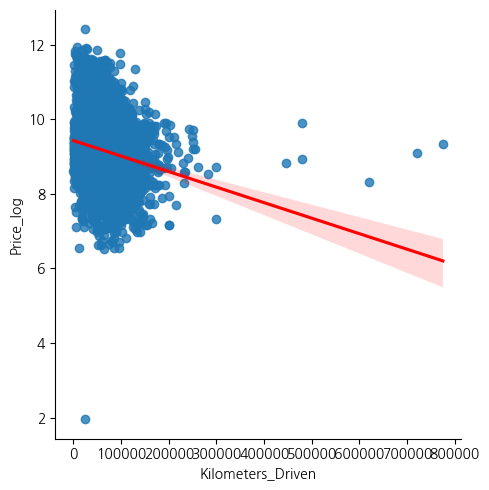

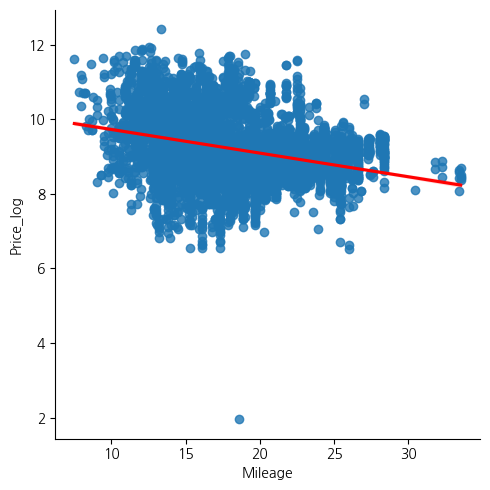

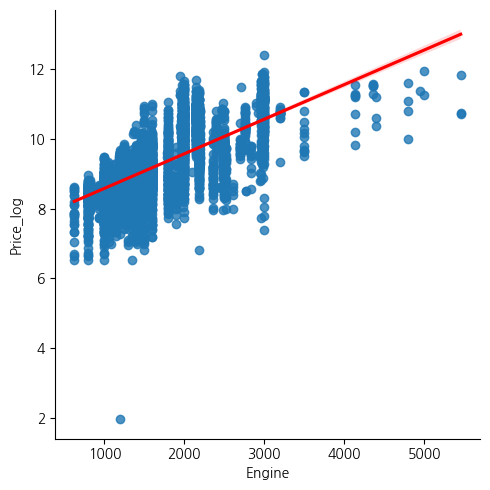

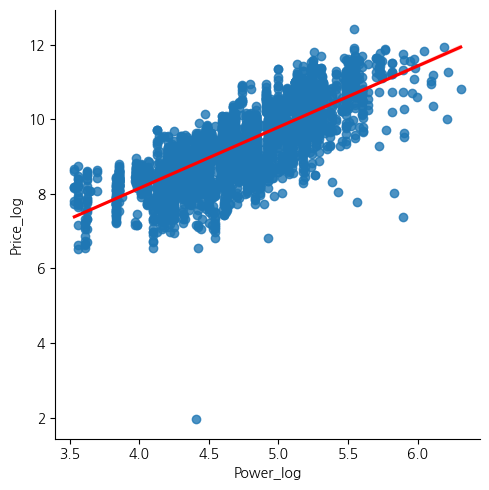

In [39]:
#fig, axs = plt.subplots(3, 2, figsize=(12, 9))
#axs = axs.flatten()

# sns.scatterplot(data=df, x='Brand', y='Price_log', ax=axs[0])
# sns.scatterplot(data=df, x='Kilometers_Driven', y='Price_log', ax=axs[1])
# sns.scatterplot(data=df, x='Mileage', y='Price_log', ax=axs[2])
# sns.scatterplot(data=df, x='Engine', y='Price_log', ax=axs[3])
# sns.scatterplot(data=df, x='Power_log', y='Price_log', ax=axs[4])
# sns.scatterplot(data=df, x='Seats', y='Price_log', ax=axs[5])

#sns.lmplot(data=df, x='Brand', y='Price_log')
sns.lmplot(data=df, x='Kilometers_Driven', y='Price_log',line_kws={'color':'red'})
sns.lmplot(data=df, x='Mileage', y='Price_log',line_kws={'color':'red'})
sns.lmplot(data=df, x='Engine', y='Price_log',line_kws={'color':'red'})
sns.lmplot(data=df, x='Power_log', y='Price_log',line_kws={'color':'red'})
#sns.lmplot(data=df, x='Seats', y='Price_log')


fig.subplots_adjust(wspace=0.4, hspace=0.6)
plt.show()

연속형 설명변수와 목표변수 Price_log 간 관계를 산점도를 통해 시각화하였다.

1. Kilometers_Driven과 Price간은 약한 음의 상관관계를 보였다. 이는 주행거리가 많을수록 가격은 낮아진다는 사실과 부합한다. 그러나 신뢰구간이 퍼져있는 경향과 산점도의 분포를 보았을 때 확신하기 어렵다.
2. Mileage와 Price간은 약한 음의 상관관계를 보였다. 이는 마일리지(연비)가 높을수록 차의 성능이 좋기 때문에 판매 금액이 높을 것이라는 가정과 불일치한다. 그러나 다른 변수의 영향도 고려해야 하고, 상관성이 약하기 때문에 그대로 가정을 유지하겠다.
3. 차량의 Engine(배기량)이 Price 간 양의 상관관계를 보였다. 이는 배기량이 커질수록, 차량의 사이즈가 커져 차량의 판매 금액이 증가하는 가정과 부합한다.
4. Power_log와 Price_log 또한 가장 큰 양의 상관관계를 보였다. 이는 출력이 높은 차량의 성능이 좋기 때문에 판매 금액이 높을 것이라는 가정과 부합한다.다.

### 데이터 분포

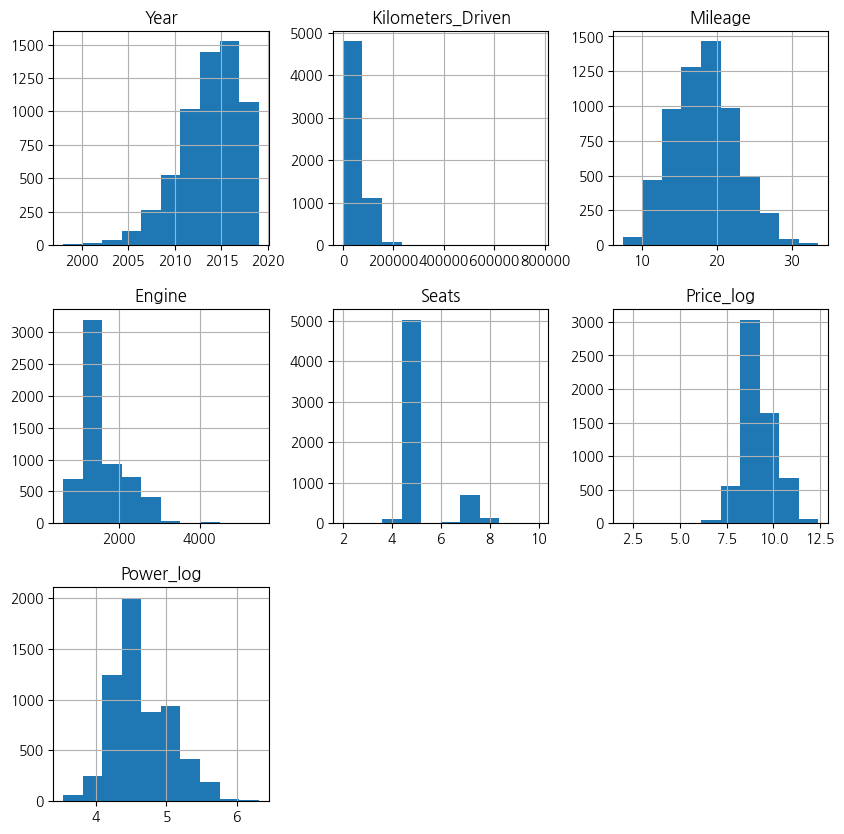

In [40]:
df.hist(figsize = (10, 10)) #히스토그램 - 데이터의 전반적인 분포를 파악
fig.subplots_adjust(wspace=0.4, hspace=0.8)

- 해석

### 상관관계

<Axes: >

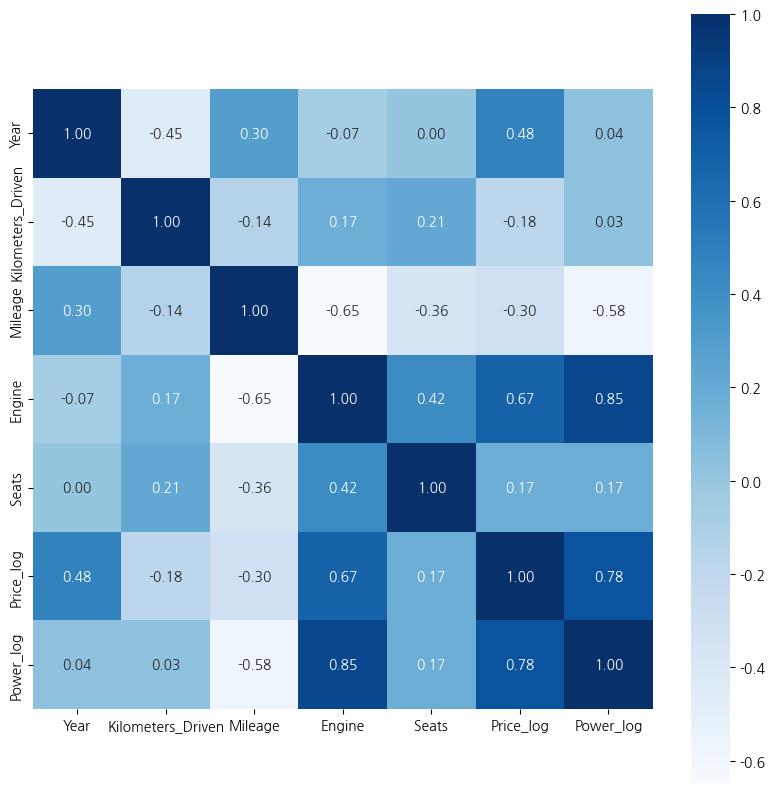

In [41]:
num = df.select_dtypes(include=np.number) 
plt.figure(figsize=(10, 10))
sns.heatmap(num.corr(), annot=True, square=True, fmt='.2f', annot_kws={'size': 10},cmap='Blues')

히트맵을 통해 수치형 변수간 상관관계를 시각화하였다.
- 설명변수와 목표변수 간 상관관계
    1. 앞서 산점도를 통해 차량의 Power_log(차량의 출력)이 Price_log(판매금액)에 영향을 끼치는 것을 추측할 수 있었다. 실제로 차량 출력과 판매금액은 높은 상관관계를 보이는 것을 확인할 수 있다.
    2. 차량의 Engine(배기량)이 증가하면 Price_log(판매금액)이 증가할 수 있다.

- 수치형 설명 변수 간 상관관계
    1. Engine과 Power_log는 0.85의 큰 양의 상관관계를 보인다.
    2. Engine과 Mileage는 -0.65로 음의 상관관계를 보인다.
    - 이러한 상관관계가 다중공선성으로 모델의 성능에 영향을 끼칠 수 있기 때문에 추후 다중공선성 검사를 통해 확인해야 한다.

### 2) 범주형 변수 간 관계

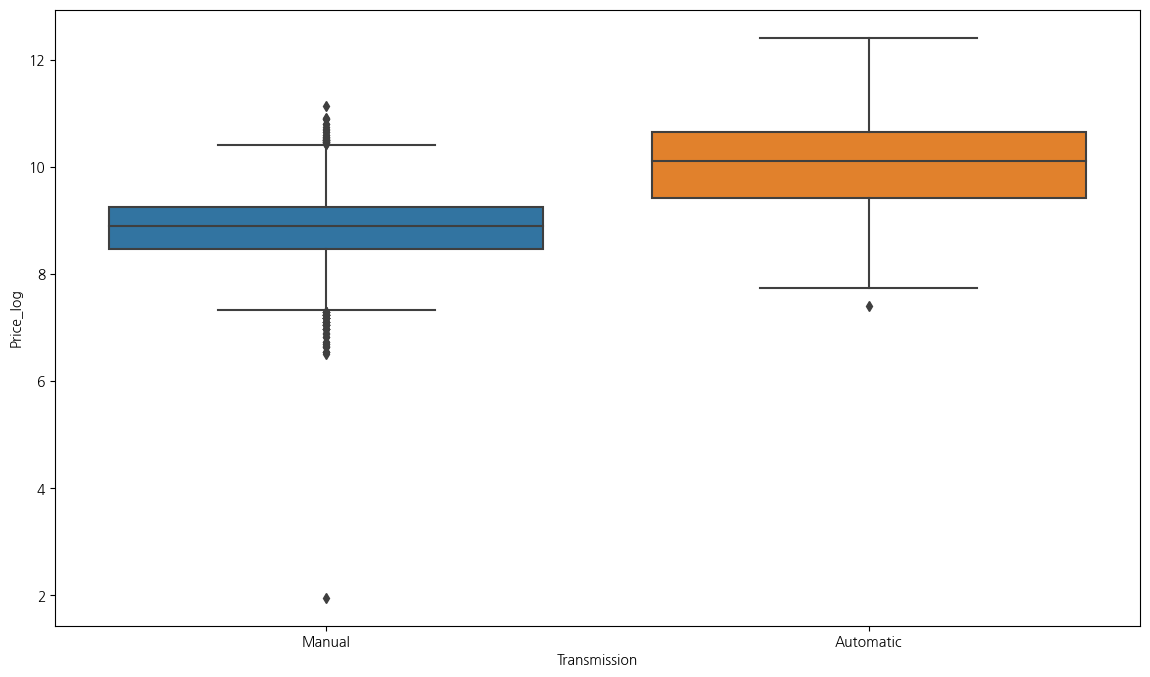

In [42]:
# Transmission과 Price_log boxplot
plt.figure(figsize=(14,8))
sns.boxplot(x='Transmission',y='Price_log',data=df)
plt.show()

차량의 Transmission에 따른 판매가격
- Automatic의 가격이 Manual에 비해 높게 형성되어있다.
- 앞서 인도의 도로 사정과 가격 문제로 manual 차량이 더 선호되는 것인 도메인 지식과 부합한다.

Text(0.5, 1.0, 'Price Distribution by Location')

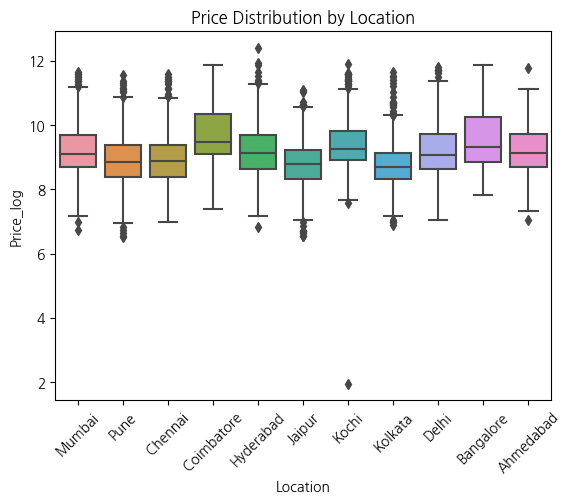

In [43]:
# Location 별 Price
sns.boxplot(x='Location', y='Price_log', data=df)
plt.xticks(rotation=45)  # X축 라벨을 45도 회전
plt.title('Price Distribution by Location')

- 지역 별 가격은 전반적으로 비슷한 분포를 형성하고 있다.
- 확신할 수는 없지만 Delhi, Mumbai, Chennai, Kolkata, Hyderabad 5개의 도시에서 특정하게 평균 가격이 높은 차량을 선호한다는 가정에 부합하지 않는다.

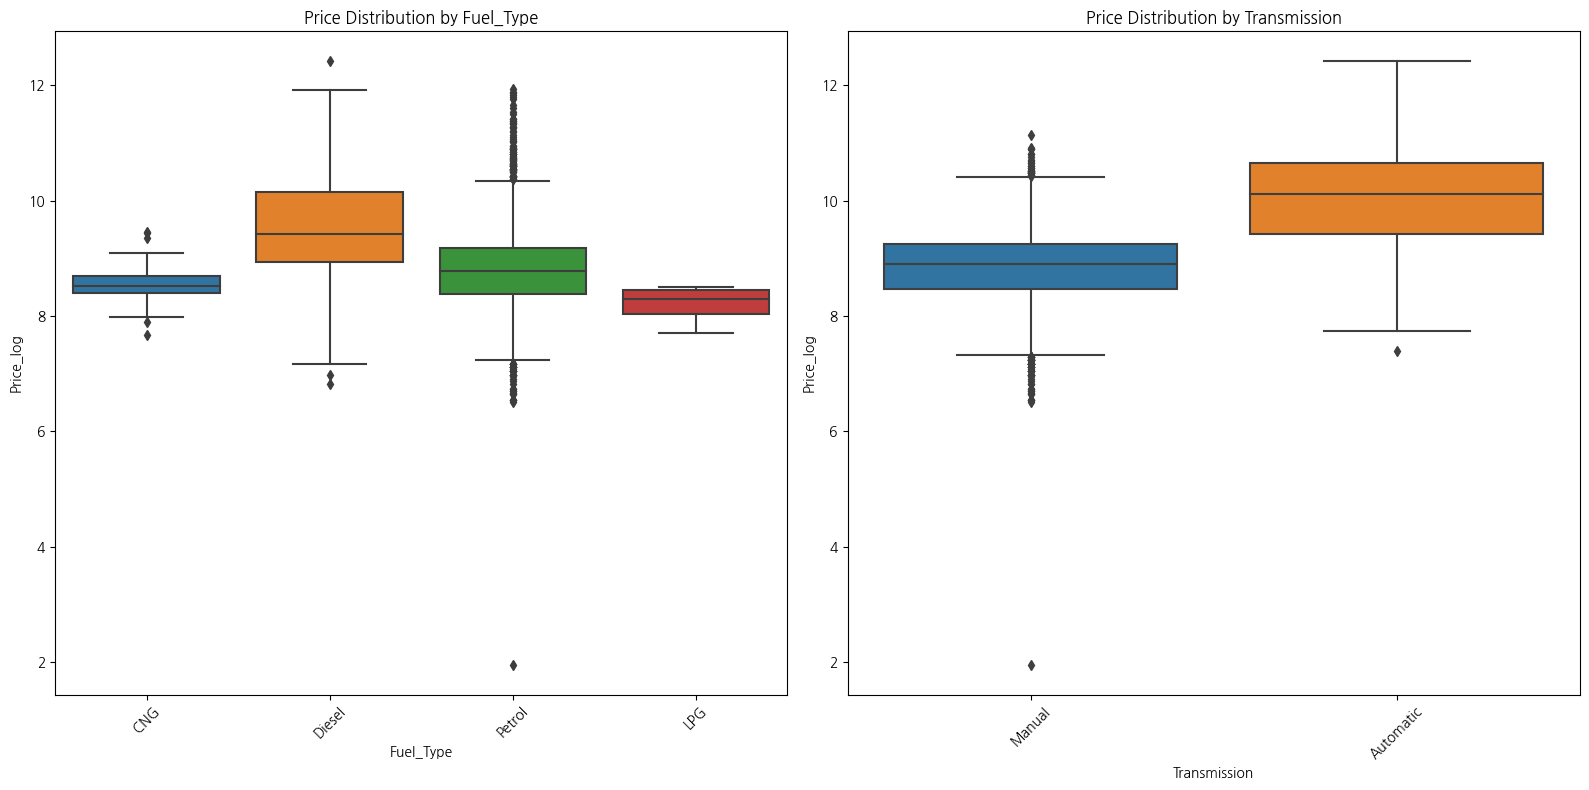

In [44]:
categorical_columns = ['Fuel_Type', 'Transmission']

# Subplots 생성
fig, axes = plt.subplots(1, len(categorical_columns), figsize=(16, 8))

# 각 범주형 변수에 대해 Boxplot 생성
for i, col in enumerate(categorical_columns):
    sns.boxplot(x=col, y='Price_log', data=df, ax=axes[i])
    axes[i].set_title(f'Price Distribution by {col}')
    axes[i].tick_params(axis='x', rotation=45)  # X축 라벨 회전

plt.tight_layout()
plt.show()

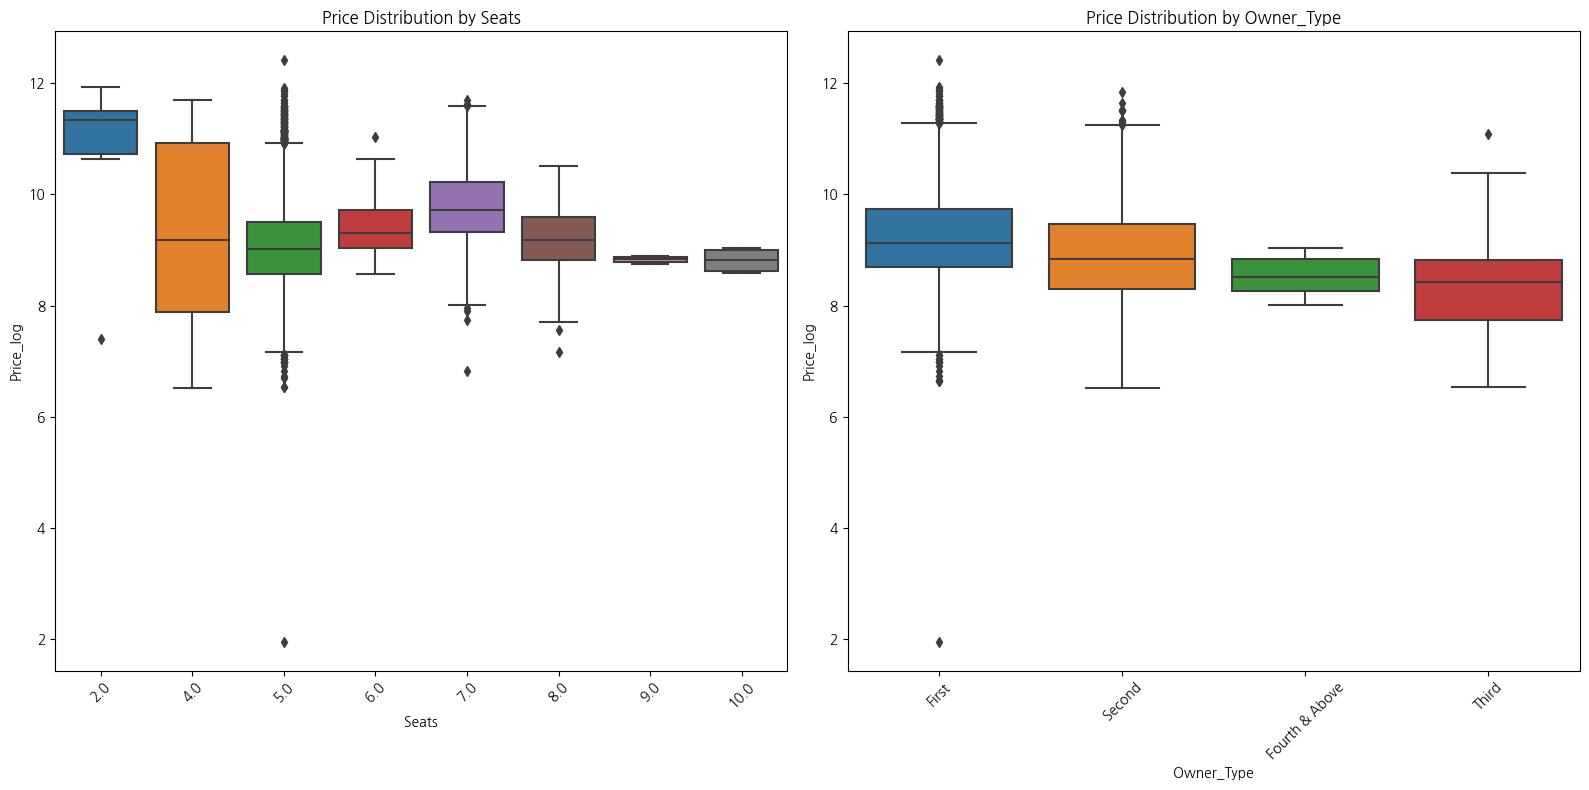

In [45]:
categorical_columns =['Seats','Owner_Type']
# Subplots 생성
fig, axes = plt.subplots(1, len(categorical_columns), figsize=(16, 8))

# 각 범주형 변수에 대해 Boxplot 생성
for i, col in enumerate(categorical_columns):
    sns.boxplot(x=col, y='Price_log', data=df, ax=axes[i])
    axes[i].set_title(f'Price Distribution by {col}')
    axes[i].tick_params(axis='x', rotation=45)  # X축 라벨 회전

plt.tight_layout()
plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 [Text(0, 0, 'Maruti'),
  Text(1, 0, 'Hyundai'),
  Text(2, 0, 'Honda'),
  Text(3, 0, 'Audi'),
  Text(4, 0, 'Nissan'),
  Text(5, 0, 'Toyota'),
  Text(6, 0, 'Volkswagen'),
  Text(7, 0, 'Tata'),
  Text(8, 0, 'Land'),
  Text(9, 0, 'Mitsubishi'),
  Text(10, 0, 'Renault'),
  Text(11, 0, 'Mercedes-Benz'),
  Text(12, 0, 'BMW'),
  Text(13, 0, 'Mahindra'),
  Text(14, 0, 'Ford'),
  Text(15, 0, 'Porsche'),
  Text(16, 0, 'Datsun'),
  Text(17, 0, 'Jaguar'),
  Text(18, 0, 'Volvo'),
  Text(19, 0, 'Chevrolet'),
  Text(20, 0, 'Skoda'),
  Text(21, 0, 'Mini'),
  Text(22, 0, 'Fiat'),
  Text(23, 0, 'Jeep')])

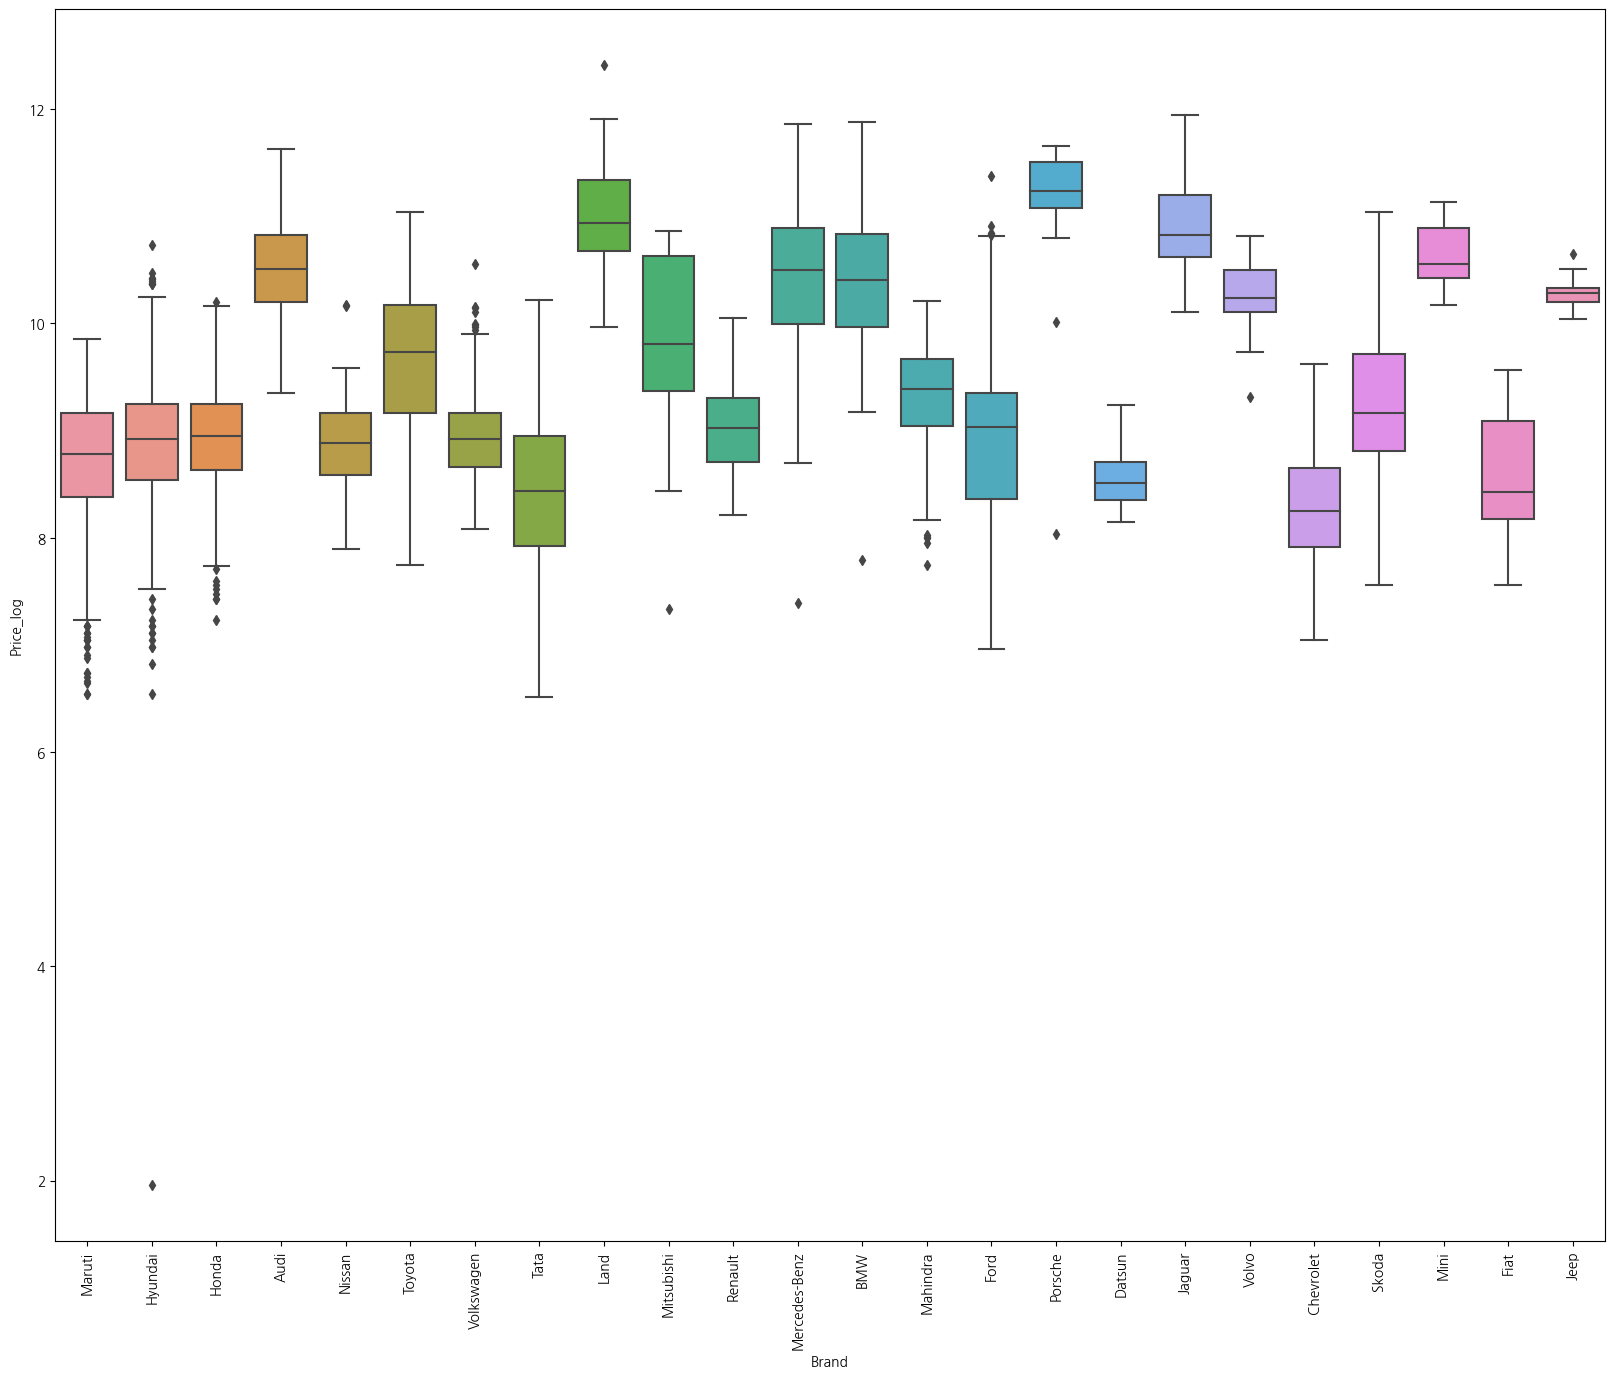

In [46]:
plt.figure(figsize=(20,16))
sns.boxplot(x='Brand',y='Price_log',data=df)
plt.xticks(rotation=90)

In [47]:
p = df['Price_log'].min()
df[df['Price_log'] == p]

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Seats,Brand,Size,Price_log,Power_log
7236,Kochi,2018,23955,Petrol,Manual,First,18.6,1197.0,5.0,Hyundai,small,1.957274,4.40501


In [48]:
# 이상치라 판단하여 제거
df=df[df['Price_log'] != p]
df['Price_log'].min()

6.51397167564781

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, 'Mumbai'),
  Text(1, 0, 'Pune'),
  Text(2, 0, 'Chennai'),
  Text(3, 0, 'Coimbatore'),
  Text(4, 0, 'Hyderabad'),
  Text(5, 0, 'Jaipur'),
  Text(6, 0, 'Kochi'),
  Text(7, 0, 'Kolkata'),
  Text(8, 0, 'Delhi'),
  Text(9, 0, 'Bangalore'),
  Text(10, 0, 'Ahmedabad')])

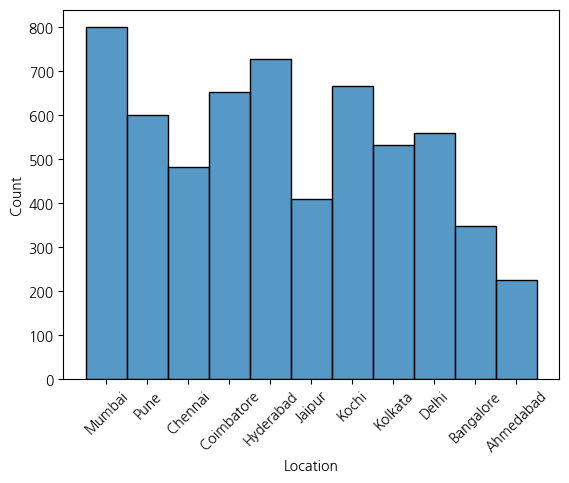

In [49]:

sns.histplot(df['Location'])
plt.xticks(rotation=45)

- 도시 상 가격의 큰 차이는 보이지 않는다.

종합적으로 분석해보았을 때, ~가지 상관관계를 고려해볼 수 있다.
1) Engine(배기량)과 가격은 양의 상관 관계를 보인다.
2) Power(최대출력)과 가격은 양의 상관 관계를 보인다.

# 4. 모델링

### 데이터 분리

In [50]:
df_train, df_test = train_test_split(df,test_size=0.3)

### Logistic Regression

In [51]:
reg_model = smf.ols(formula = "Price_log ~ Year + Kilometers_Driven + Mileage + Engine + Power_log ", data = df_train)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:              Price_log   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     4193.
Date:                Sun, 11 Aug 2024   Prob (F-statistic):               0.00
Time:                        21:04:20   Log-Likelihood:                -1545.0
No. Observations:                4209   AIC:                             3102.
Df Residuals:                    4203   BIC:                             3140.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          -250.3866      4.17

In [52]:
cols = df_train.select_dtypes(['int','float']).columns
df_train_const = add_constant(df_train[cols])
df_vif = pd.DataFrame()
df_vif['variable'] = df_train_const.columns
df_vif["VIF"] = [variance_inflation_factor(df_train_const.values, i) for i in range(df_train_const.shape[1])]
df_vif.sort_values('VIF', ascending = True).round(2)

# VIF 검사 상 이상 X

,variable,VIF
2,Kilometers_Driven,1.41
5,Seats,1.58
3,Mileage,2.08
1,Year,2.86
4,Engine,5.97
6,Price_log,5.99
7,Power_log,6.84
0,const,1161922.99


- 해석

### 연속형 변수 vs 연속형 변수 : 상관분석

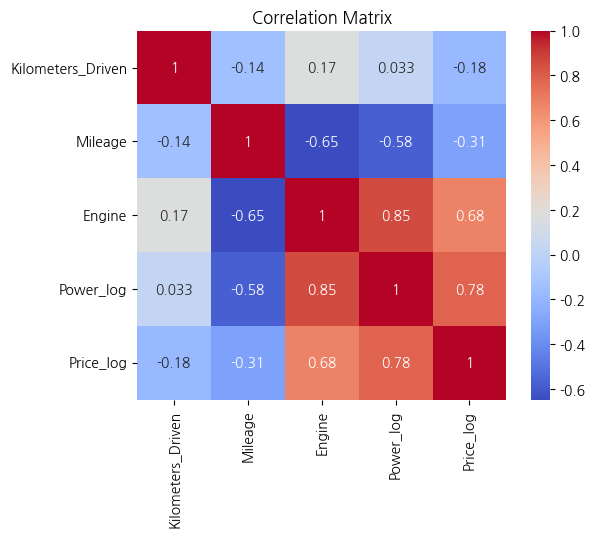

Correlation with Price_log:
Kilometers_Driven   -0.182260
Mileage             -0.306506
Engine               0.676819
Power_log            0.783110
Price_log            1.000000
Name: Price_log, dtype: float64


In [53]:
# 상관 분석
variables = ['Kilometers_Driven', 'Mileage', 'Engine', 'Power_log']

# 변수들 간의 상관 계수 행렬 계산
corr_matrix = df[variables + ['Price_log']].corr()

# Heatmap으로 상관 계수 행렬 시각화
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

# Price_log과 각 변수들 간의 상관 계수
print('Correlation with Price_log:')
print(corr_matrix['Price_log'])

### 범주형 vs 범주형 비교 : 카이제곱 검정

In [54]:
from scipy.stats import chi2_contingency

# 범주형 변수 선택
categorical_variables = ['Fuel_Type', 'Transmission', 'Seats', 'Owner_Type', 'Brand']

# 각 변수와 Price_log 간의 독립성을 평가하는 카이제곱 검정 수행
for var in categorical_variables:
    contingency_table = pd.crosstab(df[var], df['Price_log'])
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    
    print(f'Chi-square test for {var}:')
    print('Chi-square statistic:', chi2)
    print('p-value:', p_value)
    print()

Chi-square test for Fuel_Type:
Chi-square statistic: 4015.9530385865764
p-value: 0.9995354977421873

Chi-square test for Transmission:
Chi-square statistic: 3577.8140047378765
p-value: 1.4629572788212097e-182

Chi-square test for Seats:
Chi-square statistic: 12781.13890062242
p-value: 1.207893964339198e-69

Chi-square test for Owner_Type:
Chi-square statistic: 2847.3505028706527
p-value: 1.0

Chi-square test for Brand:
Chi-square statistic: 48778.6825628094
p-value: 0.0



- 해석

### 범주형 vs 연속형 : ANOVA

In [55]:
# 범주형 변수 선택
categorical_variables = ['Fuel_Type', 'Transmission', 'Seats', 'Owner_Type', 'Brand']

# 각 범주형 변수와 Price_log 간의 ANOVA 검정 수행
for var in categorical_variables:
    formula = f'Price_log ~ C({var})'  # ANOVA 모델 formula 생성
    model = ols(formula, data=df).fit()  # ANOVA 모델 피팅
    anova_table = sm.stats.anova_lm(model)  # ANOVA 결과 테이블 생성
    
    print(f'ANOVA test for {var}:')
    print(anova_table)
    print()

ANOVA test for Fuel_Type:
                  df       sum_sq     mean_sq           F         PR(>F)
C(Fuel_Type)     3.0   829.018841  276.339614  451.612699  1.320279e-264
Residual      6009.0  3676.877871    0.611895         NaN            NaN

ANOVA test for Transmission:
                     df       sum_sq      mean_sq            F  PR(>F)
C(Transmission)     1.0  1680.343566  1680.343566  3574.714276     0.0
Residual         6011.0  2825.553147     0.470064          NaN     NaN

ANOVA test for Seats:
              df       sum_sq    mean_sq          F        PR(>F)
C(Seats)     7.0   331.266632  47.323805  68.072965  5.897999e-95
Residual  6005.0  4174.630080   0.695192        NaN           NaN

ANOVA test for Owner_Type:
                   df       sum_sq    mean_sq          F        PR(>F)
C(Owner_Type)     3.0   166.955408  55.651803  77.072184  6.479045e-49
Residual       6009.0  4338.941305   0.722074        NaN           NaN

ANOVA test for Brand:
              df       sum_

- 해석

### 범주형 변수 변환

In [56]:
df['Location'].unique()

array(['Mumbai', 'Pune', 'Chennai', 'Coimbatore', 'Hyderabad', 'Jaipur',
       'Kochi', 'Kolkata', 'Delhi', 'Bangalore', 'Ahmedabad'],
      dtype=object)

In [57]:
loc = df['Location'].values
list1=['Mumbai', 'Pune', 'Chennai', 'Coimbatore', 'Hyderabad', 'Jaipur',
       'Kochi', 'Kolkata', 'Delhi', 'Bangalore', 'Ahmedabad']

In [58]:
#Owner_Type값을 수치형으로 변환
#re_Owner_Type = {'First': 1, 'Second': 2, 'Third': 3, 'Fourth & Above': 4}
#df['Owner_Type'] = df['Owner_Type'].map(re_Owner_Type)

# Fuel_Type의 데이터 값을 0, 1, 2, 3, 4로 변경
# Diesel -> 0, Petrol -> 1, CNG -> 2, 'LPG' -> 3, 'Electric' -> 4
df['Fuel_Type'] = df['Fuel_Type'].replace('Diesel', 0)
df['Fuel_Type'] = df['Fuel_Type'].replace('Petrol', 1)
df['Fuel_Type'] = df['Fuel_Type'].replace('CNG', 2)
df['Fuel_Type'] = df['Fuel_Type'].replace('LPG', 3)
df['Fuel_Type'] = df['Fuel_Type'].replace('Electric', 4)

# Transmission의 데이터 값을 1, 2로 변경
# Manual -> 1, Automatic -> 2
df['Transmission'] = df['Transmission'].replace('Manual', 1)
df['Transmission'] = df['Transmission'].replace('Automatic', 2)

#df['Location']=df['Location'].replace({"Mumbai":0,})

for i,l in enumerate(list1):
    df['Location'] = df['Location'].replace({l: i})

df['Fuel_Type'] = df['Fuel_Type'].astype('int64') # 타입 변환
df['Transmission'] = df['Transmission'].astype('int64')

df['Size']=df['Size'].replace({'light':0, 'small':1,'mid':2,'full':3})

In [59]:
from sklearn.preprocessing import LabelEncoder #Brand 데이터 값 수치형으로 변환

le = LabelEncoder()
df['Brand'] = le.fit_transform(df['Brand'])

brand_mapping = dict(zip(le.classes_, range(len(le.classes_))))
print(brand_mapping)

{'Audi': 0, 'BMW': 1, 'Chevrolet': 2, 'Datsun': 3, 'Fiat': 4, 'Ford': 5, 'Honda': 6, 'Hyundai': 7, 'Jaguar': 8, 'Jeep': 9, 'Land': 10, 'Mahindra': 11, 'Maruti': 12, 'Mercedes-Benz': 13, 'Mini': 14, 'Mitsubishi': 15, 'Nissan': 16, 'Porsche': 17, 'Renault': 18, 'Skoda': 19, 'Tata': 20, 'Toyota': 21, 'Volkswagen': 22, 'Volvo': 23}


In [60]:
le = LabelEncoder()
df['Owner_Type'] = le.fit_transform(df['Owner_Type'])


In [61]:
df['Location'].value_counts()

0     800
4     729
6     667
3     653
1     600
8     560
7     534
2     484
5     410
9     349
10    227
Name: Location, dtype: int64

In [62]:
df_raw_y = df['Price_log']
df_raw_x = df.drop(['Price_log'], axis = 1, inplace = False)

In [63]:
# 데이터 분할(train, test 데이터 7:3 비율로 분할)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, test_size = 0.3)

print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))    

train data X size : (4209, 12)
train data Y size : (4209,)
test data X size : (1804, 12)
test data Y size : (1804,)


In [64]:
df_train_x['Owner_Type'].unique()

array([0, 2, 3, 1])

In [65]:
# 기본 옵션으로 모델 생성
tree_uncustomized = DecisionTreeRegressor()
tree_uncustomized.fit(df_train_x, df_train_y)

print('Score on training set: {:.3f}'.format(tree_uncustomized.score(df_train_x, df_train_y)))
print('Score on test set: {:.3f}'.format(tree_uncustomized.score(df_test_x, df_test_y)))

Score on training set: 1.000
Score on test set: 0.851


In [66]:
# 최적 파라미터 튜닝 : min_samples_leaf
# train 및 test 설명력 결과 저장
train_score = []; test_score = [ ]
# min_samples_leaf: 잎사귀 최소 자료 수
para_leaf = [n_leaf for n_leaf in range(1, 20)]

for v_min_samples_leaf in para_leaf:
    tree = DecisionTreeRegressor(min_samples_leaf=v_min_samples_leaf)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))

# 결과 저장
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesLeaf"] = para_leaf
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score
# 모델 설명력 확인
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,1.000,0.849
1,2,0.979,0.867
2,3,0.964,0.878
3,4,0.954,0.887
4,5,0.945,0.889
5,6,0.938,0.889
6,7,0.933,0.887
7,8,0.928,0.886
8,9,0.924,0.887
9,10,0.920,0.884


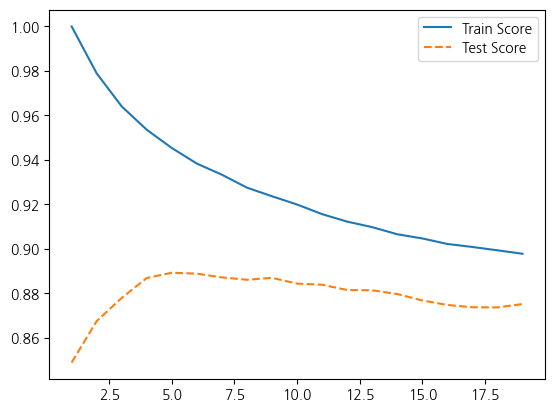

In [67]:
# 모델 설명력 그래프 확인
plt.plot(para_leaf, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_leaf, test_score, linestyle = "--", label = "Test Score")
plt.legend()
# min_samples_leaf 7 선택

In [68]:
# min_samples_split 설정
# train 및 test 설명력 결과 저장
train_score = []; test_score = []
# min_samples_split: 분리 노드의 최소 자료 수 
para_split = [n_split * 2 for n_split in range(2, 20)]

for v_min_samples_split in para_split:
    tree = DecisionTreeRegressor( min_samples_leaf=7
                                 , min_samples_split=v_min_samples_split )
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))

# 결과 저장
df_score_split = pd.DataFrame()
df_score_split["MinSamplesSplit"] = para_split
df_score_split["TrainScore"] = train_score
df_score_split["TestScore"] = test_score
df_score_split.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,4,0.933,0.887
1,6,0.933,0.887
2,8,0.933,0.887
3,10,0.933,0.887
4,12,0.933,0.887
5,14,0.933,0.887
6,16,0.930,0.885
7,18,0.929,0.886
8,20,0.927,0.885
9,22,0.924,0.886


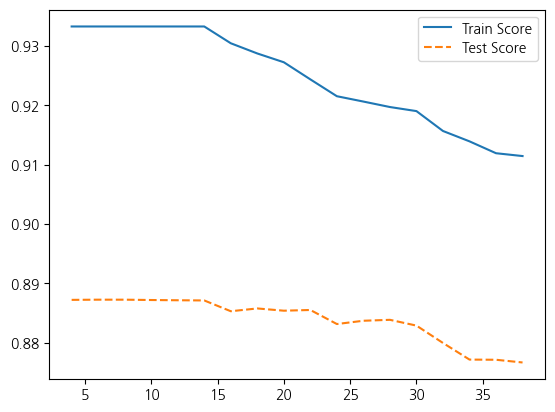

In [69]:
# 모델 설명력 그래프 확인
plt.plot(para_split, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_split, test_score, linestyle = "--", label = "Test Score")
plt.legend()
# min_samples_split 14 선택

In [70]:
# max_depth 설정
# train 및 test 설명력 결과 저장
train_score = []; test_score = []
# max_depth: 최대 깊이 변경
para_depth = [depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    tree = DecisionTreeRegressor(min_samples_leaf=7, min_samples_split=14
                                  , max_depth = v_max_depth)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_score_depth = pd.DataFrame()
df_score_depth["Depth"] = para_depth
df_score_depth["TrainScore"] = train_score
df_score_depth["TestScore"] = test_score
df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.484,0.438
1,2,0.640,0.614
2,3,0.748,0.733
3,4,0.804,0.788
4,5,0.848,0.831
5,6,0.876,0.858
6,7,0.896,0.868
7,8,0.909,0.875
8,9,0.919,0.880
9,10,0.926,0.884


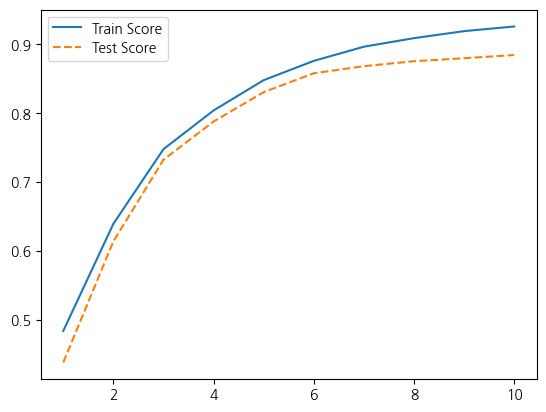

In [71]:
# 모델 설명력 그래프 확인
plt.plot(para_depth, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_depth, test_score, linestyle = "--", label = "Test Score")
plt.legend()
# max_depth 8 선택

In [73]:
# 최종 모델
dt_final = DecisionTreeRegressor( min_samples_leaf = 7,
                                 min_samples_split = 14, max_depth = 8)
dt_final.fit(df_train_x, df_train_y)
# Train 데이터 설명력
print("Score on training set: {:.3f}".format(dt_final.score(df_train_x, df_train_y)))
# Test 데이터 설명력
print("Score on test set: {:.3f}".format(dt_final.score(df_test_x, df_test_y)))

Score on training set: 0.909
Score on test set: 0.875


In [106]:
# GridSearchCV를 이용한 최적 parameter 찾기 
from sklearn.model_selection import GridSearchCV
para_depth = [depth for depth in range(1,11)]
para_split = [n_split*2 for n_split in range(2,20)]
para_leaf = [n_leaf * 2 for n_leaf in range(1,20)]

estimator = DecisionTreeRegressor()

param_grid = {"criterion": ["squared_error","friedman_mse","absolute_error"], "max_features" : [1.0],
                 "max_depth" : para_depth, "min_samples_split" : para_split, "min_samples_leaf" : para_leaf}

grid_dt = GridSearchCV(estimator, param_grid, scoring = "r2", n_jobs = -1)
grid_dt.fit(df_train_x, df_train_y)

print("best estimator model : \n{}".format(grid_dt.best_estimator_))
print("\n best parameter : \n {}".format(grid_dt.best_params_))
print("\n best score : \n {}".format(grid_dt.best_score_.round(3)))


best estimator model : 
DecisionTreeRegressor(max_depth=10, max_features=1.0, min_samples_leaf=6,
                      min_samples_split=14)

 best parameter : 
 {'criterion': 'squared_error', 'max_depth': 10, 'max_features': 1.0, 'min_samples_leaf': 6, 'min_samples_split': 14}

 best score : 
 0.868


- DT의 최적 파라미터 : 'max_depth': 10, 'max_features': 1.0, 'min_samples_leaf': 6, 'min_samples_split': 14
- 설명력 : 0.868

In [74]:
# DT 최종 모델 선정
tree_final = DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 6, min_samples_split = 14)
tree_final.fit(df_train_x, df_train_y)

print('Score on training set: {:.3f}'.format(tree_final.score(df_train_x, df_train_y)))
print('Score on test set: {:.3f}'.format(tree_final.score(df_test_x, df_test_y)))

Score on training set: 0.928
Score on test set: 0.883


In [75]:
# 설명변수 중요도 확인 및 테이블로 저장

v_feature_name = df_train_x.columns

df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = tree_final.feature_importances_

df_importance.sort_values('Importance', ascending = False, inplace = True)
df_importance.round(3)

,Feature,Importance
11,Power_log,0.691
1,Year,0.236
7,Engine,0.018
9,Brand,0.013
6,Mileage,0.012
0,Location,0.008
10,Size,0.008
2,Kilometers_Driven,0.006
3,Fuel_Type,0.005
4,Transmission,0.003


Text(0, 0.5, '변수')

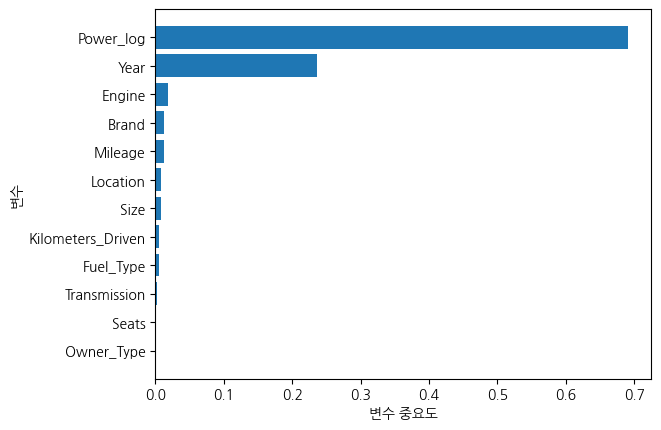

In [76]:
# 설명변수 중요도 그래프
df_importance.sort_values('Importance', ascending = True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')

- GridSearch를 통해 구한 최적의 파라미터 값을 max_depth = 8, min_samples_leaf = 7, min_samples_split = 14로 설정하였다.
- 최적의 파라미터 값으로 구성한 최종 모델의 성능은 train 0.928 / test 0.886의 설명력을 보였다. 과적합으로 판단되지 않는다.
- 주요 인자를 추출한 결과, Power(최대 출력)이 Price에 가장 큰 영향을 끼치는 것으로 판단된다.
- 또한 Year 또한 Price에 영향을 미치는 2번째 주요 인자로 판단된다.


### Randomforest

In [77]:
rf_uncustomized = RandomForestRegressor()
rf_uncustomized.fit(df_train_x, df_train_y)

print('Score on training set: {:.3f}'.format(rf_uncustomized.score(df_train_x, df_train_y)))
print('Score on test set: {:.3f}'.format(rf_uncustomized.score(df_test_x, df_test_y)))

Score on training set: 0.987
Score on test set: 0.925


In [78]:
# 최적 파라미터 튜닝 : n_estimators
# train 및 test 설명력 결과 저장
train_score = []; test_score = []
# n_estimatos: 트리 수 변경: 1~100
para_n_tree = [n_tree * 10 for n_tree in range(1, 11)]

for v_n_estimators in para_n_tree:
    rf = RandomForestRegressor(n_estimators = v_n_estimators)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))

# 결과 저장
df_score_n = pd.DataFrame()
df_score_n["n_estimators"] = para_n_tree
df_score_n["TrainScore"] = train_score
df_score_n["TestScore"] = test_score
df_score_n.round(3)

,n_estimators,TrainScore,TestScore
0,10,0.982,0.919
1,20,0.986,0.922
2,30,0.987,0.925
3,40,0.986,0.924
4,50,0.986,0.923
5,60,0.988,0.926
6,70,0.987,0.925
7,80,0.987,0.924
8,90,0.987,0.925
9,100,0.987,0.924


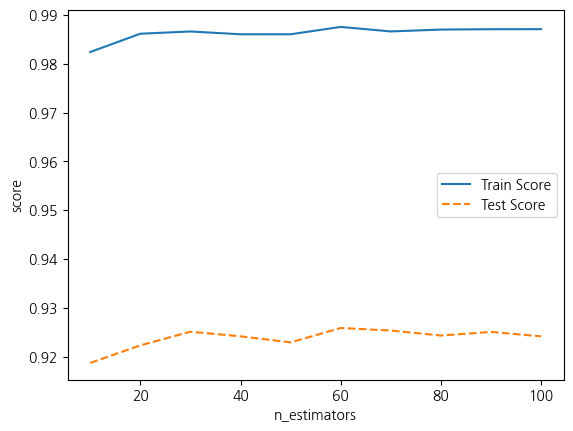

In [79]:
# 모델 설명력 그래프 확인
plt.plot(para_n_tree, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_n_tree, test_score, linestyle = "--", label = "Test Score")
plt.ylabel("score"); plt.xlabel("n_estimators")
plt.legend()
# 80 선택

In [80]:
# min_samples_leaf
# train 및 test 설명력 결과 저장
train_score = []; test_score = []
# min_samples_leaf: 잎사귀 최소 자료 수 
para_leaf = [n_leaf for n_leaf in range(1, 21)]

for v_min_samples_leaf in para_leaf:
    rf = RandomForestRegressor( n_estimators = 80,
                                min_samples_leaf = v_min_samples_leaf)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesLeaf"] = para_leaf
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score

df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.987,0.926
1,2,0.975,0.925
2,3,0.964,0.922
3,4,0.955,0.920
4,5,0.948,0.917
5,6,0.943,0.914
6,7,0.938,0.911
7,8,0.933,0.908
8,9,0.929,0.907
9,10,0.926,0.905


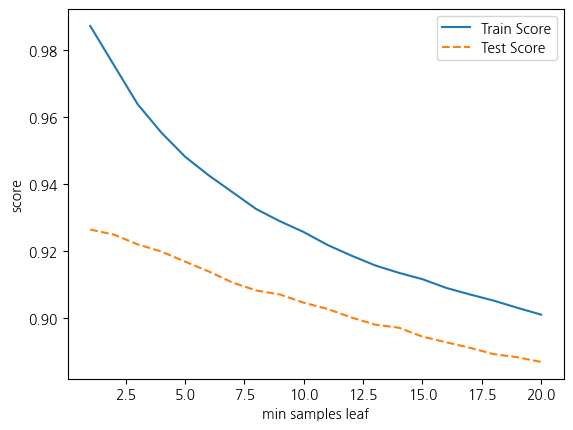

In [81]:
# 모델 설명력 그래프 확인
plt.plot(para_leaf, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_leaf, test_score, linestyle = "--", label = "Test Score")
plt.ylabel("score"); plt.xlabel("min samples leaf")
plt.legend()
# min_samples_leaf 5 선택

In [82]:
# min_samples_split
# train 및 test 설명력 결과 저장
train_score = []; test_score = []
# min_samples_split: 분할하기 위한 노드의 최소 자료 수 
para_split = [n_split * 2for n_split in range(2, 21)]

for v_min_samples_split in para_split:
    rf = RandomForestRegressor(n_estimators = 80, min_samples_leaf = 5,
                               min_samples_split = v_min_samples_split)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_score_split = pd.DataFrame()
df_score_split["MinSamplesSplit"] = para_split
df_score_split["TrainScore"] = train_score
df_score_split["TestScore"] = test_score
df_score_split.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,4,0.948,0.916
1,6,0.949,0.916
2,8,0.948,0.916
3,10,0.948,0.917
4,12,0.946,0.916
5,14,0.943,0.915
6,16,0.941,0.913
7,18,0.939,0.913
8,20,0.936,0.911
9,22,0.935,0.911


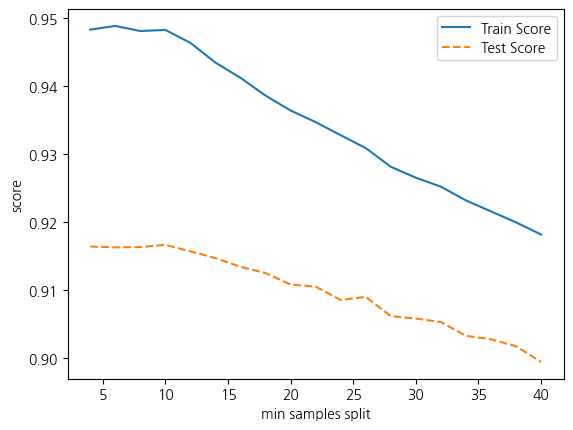

In [83]:
# 모델 설명력 그래프 확인
plt.plot(para_split, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_split, test_score, linestyle = "--", label = "Test Score")
plt.ylabel("score"); plt.xlabel("min samples split")
plt.legend()
# min_samples_split 10 선택

In [84]:
# max_depth
# train 및 test 설명력 결과 저장
train_score = []; test_score = []
para_depth = [depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    rf = RandomForestRegressor(n_estimators = 80,
                               min_samples_leaf = 5, min_samples_split = 10,
                               max_depth = v_max_depth)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_score_depth = pd.DataFrame()
df_score_depth["Depth"] = para_depth
df_score_depth["TrainScore"] = train_score
df_score_depth["TestScore"] = test_score
df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.511,0.483
1,2,0.680,0.664
2,3,0.778,0.771
3,4,0.830,0.818
4,5,0.872,0.862
5,6,0.898,0.883
6,7,0.915,0.895
7,8,0.927,0.903
8,9,0.936,0.910
9,10,0.941,0.913


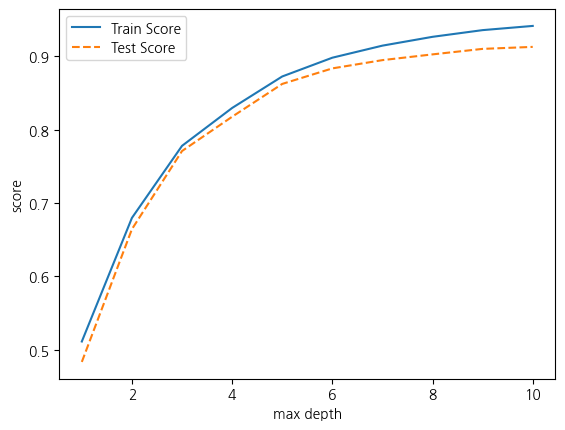

In [85]:
# 모델 설명력 그래프 확인
plt.plot(para_depth, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_depth, test_score, linestyle = "--", label = "Test Score")
plt.ylabel("score"); plt.xlabel("max depth")
plt.legend()

# max_depth 10 선택

In [86]:
# 최종 모델 선정
rf_final = RandomForestRegressor(n_estimators = 80, min_samples_leaf = 5,
                                 min_samples_split = 10, max_depth = 10)
rf_final.fit(df_train_x, df_train_y)
# Train 데이터 설명력
print("Score on training set: {:.3f}".format(rf_final.score(df_train_x, df_train_y)))
# Test 데이터 설명력
print("Score on test set: {:.3f}".format(rf_final.score(df_test_x, df_test_y)))

Score on training set: 0.942
Score on test set: 0.913


In [117]:
para_n_tree = [n_tree * 10 for n_tree in range(1, 11)]
para_leaf = [n_leaf * 1 for n_leaf in range(1, 21)]
para_split = [n_split * 2 for n_split in range(2, 21)]
para_depth = [depth for depth in range(1, 11)]

estimator = RandomForestRegressor()

param_grid = {"criterion": ["mse","friedman_mse","mae"], "max_features" : [1.0],
                 "max_depth" : para_depth, "min_samples_split" : para_split, "min_samples_leaf" : para_leaf,
             "n_estimators" : para_n_tree}

grid_dt = GridSearchCV(estimator, param_grid, scoring = "r2", n_jobs = -1)
grid_dt.fit(df_train_x, df_train_y)

print("best estimator model : \n{}".format(grid_dt.best_estimator_))
print("\n best parameter : \n {}".format(grid_dt.best_params_))
print("\n best score : \n {}".format(grid_dt.best_score_.round(3)))

# max_depth=9, max_features=1.0,min_samples_leaf=6, min_samples_split=16

best estimator model : 
RandomForestRegressor(criterion='friedman_mse', max_depth=10,
                      min_samples_leaf=2, min_samples_split=4)

 best parameter : 
 {'criterion': 'friedman_mse', 'max_depth': 10, 'max_features': 1.0, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 100}

 best score : 
 0.903


In [87]:
# 변수 중요도
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = rf_final.feature_importances_

# df_feature_importance의 테이블을 중요도 순으로 정렬
df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
11,Power_log,0.681
1,Year,0.235
7,Engine,0.023
6,Mileage,0.013
9,Brand,0.013
2,Kilometers_Driven,0.011
0,Location,0.008
4,Transmission,0.005
10,Size,0.004
3,Fuel_Type,0.003


Text(0, 0.5, '변수')

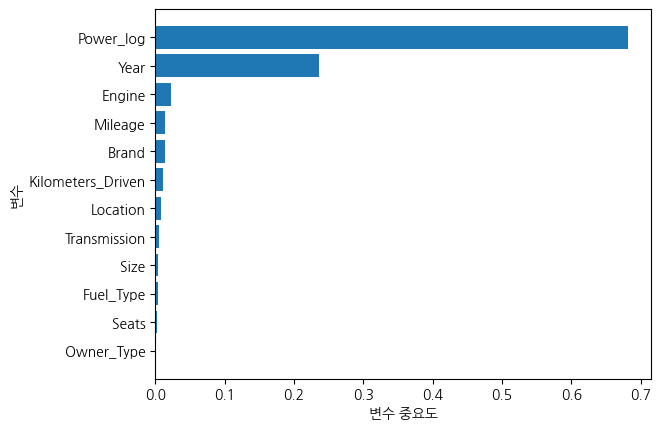

In [88]:
# 중요도가 높은 변수를 상위에 그림
df_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

- GridSearch와 수작업으로 구한 최적의 파라미터 값을 n_estimators = 80, min_samples_leaf = 5, min_samples_split = 10, max_depth = 10으로 설정하였다.
- 최적의 파라미터 값으로 구성한 최종 모델의 성능은 train 0.941 / test 0.916의 설명력을 보였다. 과적합으로 판단되지 않는다.
- 주요 인자를 추출한 결과, Power(최대 출력)이 Price에 가장 큰 영향을 끼치는 것으로 판단된다.
- 또한 Year 또한 Price에 영향을 미치는 2번째 주요 인자로 판단된다.

### GradientBoosting

In [89]:
gb_uncustomized = GradientBoostingRegressor()
gb_uncustomized.fit(df_train_x, df_train_y)

print('Score on training set: {:.3f}'.format(gb_uncustomized.score(df_train_x, df_train_y)))
print('Score on test set: {:.3f}'.format(gb_uncustomized.score(df_test_x, df_test_y)))

Score on training set: 0.933
Score on test set: 0.919


In [90]:
# 최적 파라미터 튜닝 : n_estimators
# train 및 test 설명력 결과 저장
train_score = []; test_score = []
# n_estimators: 트리 수 변경(10~100)
para_n_tree = [n_tree * 10 for n_tree in range(1, 11)]

for v_n_estimators in para_n_tree:
    gb = GradientBoostingRegressor(n_estimators = v_n_estimators)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))

# 결과 저장
df_score_n = pd.DataFrame()
df_score_n["Estimators"] = para_n_tree
df_score_n["TrainScore"] = train_score
df_score_n["TestScore"] = test_score

df_score_n.round(3)

,Estimators,TrainScore,TestScore
0,10,0.709,0.711
1,20,0.845,0.844
2,30,0.882,0.878
3,40,0.898,0.891
4,50,0.909,0.900
5,60,0.915,0.905
6,70,0.921,0.911
7,80,0.925,0.915
8,90,0.930,0.918
9,100,0.933,0.919


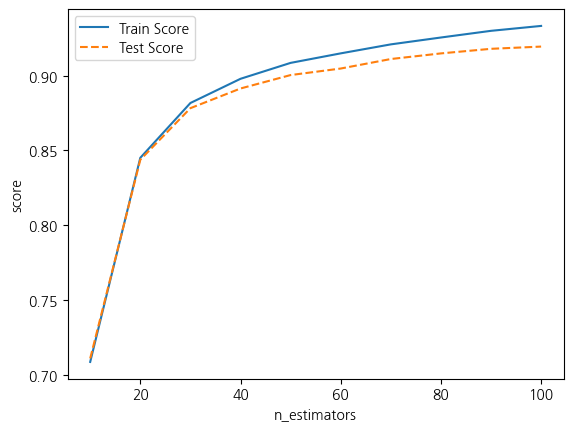

In [91]:
# 모델 설명력 그래프 확인
plt.plot(para_n_tree, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_n_tree, test_score, linestyle = "--", label = "Test Score")
plt.ylabel("score"); plt.xlabel("n_estimators")
plt.legend()
# n-estimators 100 선택

In [92]:
# min_samples_leaf
# train 및 test 설명력 결과 저장
train_score = []; test_score = []
# min_samples_leaf: 잎사귀 최소 자료 수 
para_leaf = [n_leaf for n_leaf in range(1, 21)]

for v_min_samples_leaf in para_leaf:
    gb = GradientBoostingRegressor(n_estimators = 100,
                                   min_samples_leaf = v_min_samples_leaf)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))

# 결과 저장
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesLeaf"] = para_leaf
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.933,0.920
1,2,0.932,0.921
2,3,0.930,0.920
3,4,0.929,0.920
4,5,0.930,0.920
5,6,0.928,0.919
6,7,0.928,0.919
7,8,0.929,0.919
8,9,0.928,0.919
9,10,0.928,0.921


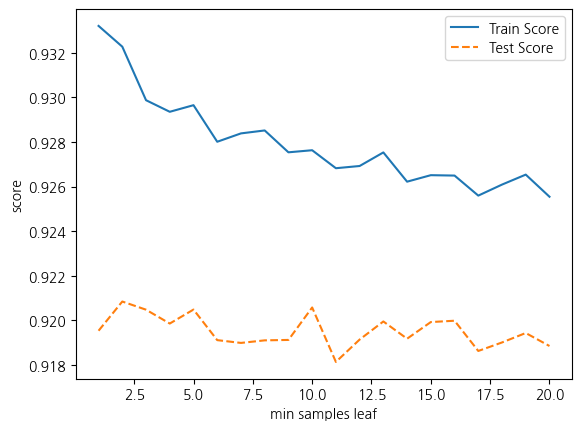

In [93]:
# 모델 설명력 그래프 확인
plt.plot(para_leaf, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_leaf, test_score, linestyle = "--", label = "Test Score")
plt.ylabel("score"); plt.xlabel("min samples leaf")
plt.legend()
# min samples leaf 10 선택

In [94]:
# min_samples_split
# train 및 test 설명력 결과 저장
train_score = []; test_score = []
# min_samples_split: 분할하기 위한 노드의 최소 자료 수 
para_split = [n_split * 2 for n_split in range(1, 21)]

for v_min_samples_split in para_split:
    gb = GradientBoostingRegressor(n_estimators = 100, min_samples_leaf = 10,
                                   min_samples_split = v_min_samples_split)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))

# 결과 저장
df_score_split = pd.DataFrame()
df_score_split["MinSamplesSplit"] = para_split
df_score_split["TrainScore"] = train_score
df_score_split["TestScore"] = test_score

df_score_split.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,2,0.928,0.921
1,4,0.928,0.921
2,6,0.928,0.921
3,8,0.928,0.921
4,10,0.928,0.921
5,12,0.928,0.921
6,14,0.928,0.921
7,16,0.928,0.921
8,18,0.928,0.921
9,20,0.928,0.921


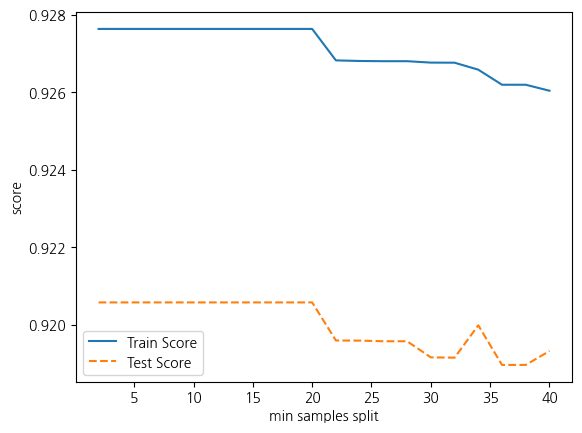

In [95]:
# 모델 설명력 그래프 확인
plt.plot(para_split, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_split, test_score, linestyle = "--", label = "Test Score")
plt.ylabel("score"); plt.xlabel("min samples split")
plt.legend()
# 지정X

In [96]:
# max_depth
# train 및 test 설명력 결과 저장
train_score = []; test_score = []
# max_depth: 최대 깊이 변경
para_depth = [depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    gb = GradientBoostingRegressor(n_estimators = 100, min_samples_leaf = 10,
                                   max_depth = v_max_depth)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))

# 결과 저장
df_score_depth = pd.DataFrame()
df_score_depth["Depth"] = para_depth
df_score_depth["TrainScore"] = train_score
df_score_depth["TestScore"] = test_score

df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.869,0.866
1,2,0.904,0.899
2,3,0.928,0.921
3,4,0.943,0.929
4,5,0.953,0.933
5,6,0.964,0.936
6,7,0.970,0.936
7,8,0.976,0.936
8,9,0.980,0.936
9,10,0.982,0.936


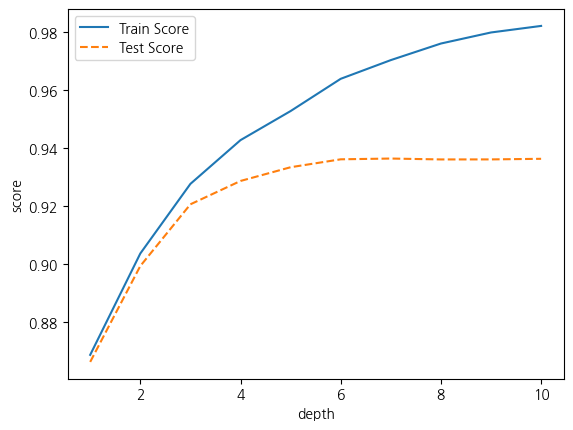

In [97]:
# 모델 설명력 그래프 확인
plt.plot(para_depth, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_depth, test_score, linestyle = "--", label = "Test Score")
plt.ylabel("score"); plt.xlabel("depth")
plt.legend()
# max_depth 6

In [98]:
# train 및 test 설명력 결과 저장
train_score = []; test_score = []
# learning rate: 학습률 변경 0.1 ~ 0.9
para_lr = [lr * 0.1 for lr in range(1, 10)]

for v_learning_rate in para_lr:
    gb = GradientBoostingRegressor(n_estimators = 100, min_samples_leaf = 10,
                                   max_depth = 6, learning_rate = v_learning_rate)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))

# 결과 저장
df_score_lr = pd.DataFrame()
df_score_lr["LearningRate"] = para_lr
df_score_lr["TrainScore"] = train_score
df_score_lr["TestScore"] = test_score

df_score_lr.round(3)

,LearningRate,TrainScore,TestScore
0,0.1,0.964,0.936
1,0.2,0.974,0.939
2,0.3,0.981,0.936
3,0.4,0.984,0.931
4,0.5,0.988,0.926
5,0.6,0.989,0.923
6,0.7,0.991,0.918
7,0.8,0.992,0.905
8,0.9,0.993,0.901


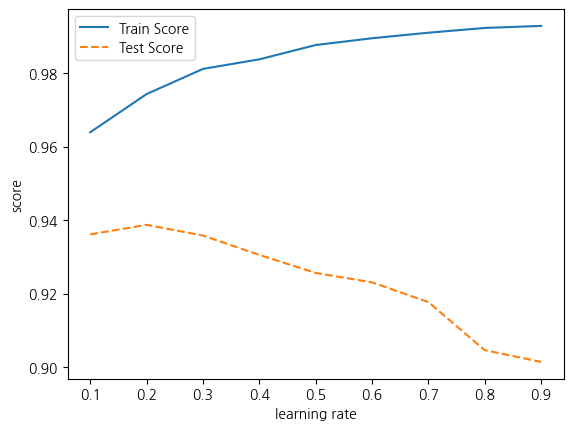

In [99]:
# 모델 설명력 그래프 확인
plt.plot(para_lr, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_lr, test_score, linestyle = "--", label = "Test Score")
plt.ylabel("score"); plt.xlabel("learning rate")
plt.legend()
# learning rate 0.1 선택

In [100]:
# 최종모델 선택
gb_final = GradientBoostingRegressor(n_estimators = 100, min_samples_leaf = 8,
                                     max_depth = 8, learning_rate = 0.1)
gb_final.fit(df_train_x, df_train_y)
# Train 데이터 설명력
print("Score on training set: {:.3f}".format(gb_final.score(df_train_x, df_train_y)))
# Test 데이터 설명력
print("Score on test set: {:.3f}".format(gb_final.score(df_test_x, df_test_y)))

Score on training set: 0.979
Score on test set: 0.939


In [101]:
# feature_importances_: 설명변수의 중요도
v_feature_name = df_train_x.columns

# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = gb_final.feature_importances_
# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
11,Power_log,0.654
1,Year,0.227
7,Engine,0.025
6,Mileage,0.020
9,Brand,0.019
2,Kilometers_Driven,0.017
0,Location,0.016
4,Transmission,0.008
3,Fuel_Type,0.006
10,Size,0.003


Text(0, 0.5, '변수')

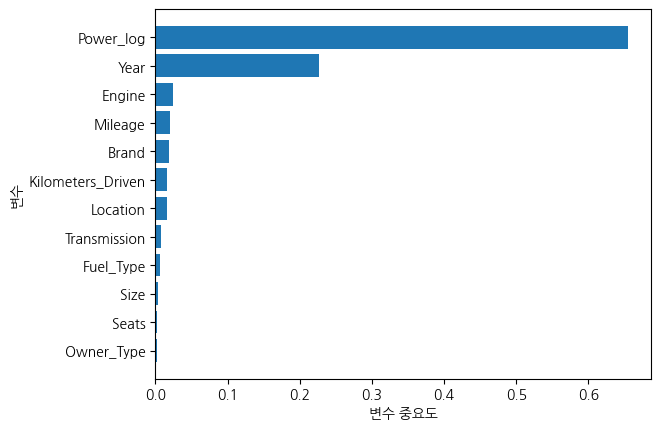

In [102]:
# 중요도가 높은 변수를 상위에 그림. 
df_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

- GridSearch와 수작업으로 구한 최적의 파라미터 값을 n_estimators = 100, min_samples_leaf = 8, max_depth = 8, learning_rate = 0.1으로 설정하였다.(min_samples_split 지정X)
- 최적의 파라미터 값으로 구성한 최종 모델의 성능은 train 0.979 / test 0.931의 설명력을 보였다. 
- 그러나 기본 옵션의 GB는 train 0.930 / test 0.922로 train의 성능은 낮지만 과적합 방지에 더 적합하고, test의 성능이 크게 차이 나지 않아 최종적으로 기본 옵션의 GB를 선택하였다.
- 주요 인자를 추출한 결과, Power(최대 출력)이 Price에 가장 큰 영향을 끼치는 것으로 판단된다.
- 또한 Year 또한 Price에 영향을 미치는 2번째 주요 인자로 판단된다.
- 세 가지 모델에서 추출한 중요인자 모두 Power_log, Year, Engine이 가장 중요한 인자로 판단되었다.

# 4. 모델 평가

In [103]:
# RMSE, MAPE 계산하는 함수 선언
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [104]:
dt_model = DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 6, min_samples_split = 14)
dt_model.fit(df_train_x, df_train_y)

rf_model = RandomForestRegressor(n_estimators = 80, min_samples_leaf = 5, 
                                 min_samples_split = 10, max_depth = 10)
rf_model.fit(df_train_x, df_train_y)

gb_model = GradientBoostingRegressor()
gb_model.fit(df_train_x, df_train_y)

GradientBoostingRegressor()

In [105]:
models = ["의사결정나무", "랜덤 포레스트", "그래디언트 부스팅"]

mse, rmse, mae, mape = [],[],[],[]

In [106]:
# DecisionTree 평가 지표 계산
dt_y_pred = dt_model.predict(df_test_x)

mse.append(mean_squared_error(df_test_y, dt_y_pred))
rmse.append(root_mean_squared_error(df_test_y, dt_y_pred))
mae.append(mean_absolute_error(df_test_y, dt_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y, dt_y_pred))

In [107]:
# RandomForest 평가 지표 계산
rf_y_pred = rf_model.predict(df_test_x)

mse.append(mean_squared_error(df_test_y, rf_y_pred))
rmse.append(root_mean_squared_error(df_test_y, rf_y_pred))
mae.append(mean_absolute_error(df_test_y, rf_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y, rf_y_pred))

In [108]:
# GradientBoosting 평가 지표 계산
gb_y_pred = gb_model.predict(df_test_x)

mse.append(mean_squared_error(df_test_y, gb_y_pred))
rmse.append(root_mean_squared_error(df_test_y, gb_y_pred))
mae.append(mean_absolute_error(df_test_y, gb_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y, gb_y_pred))

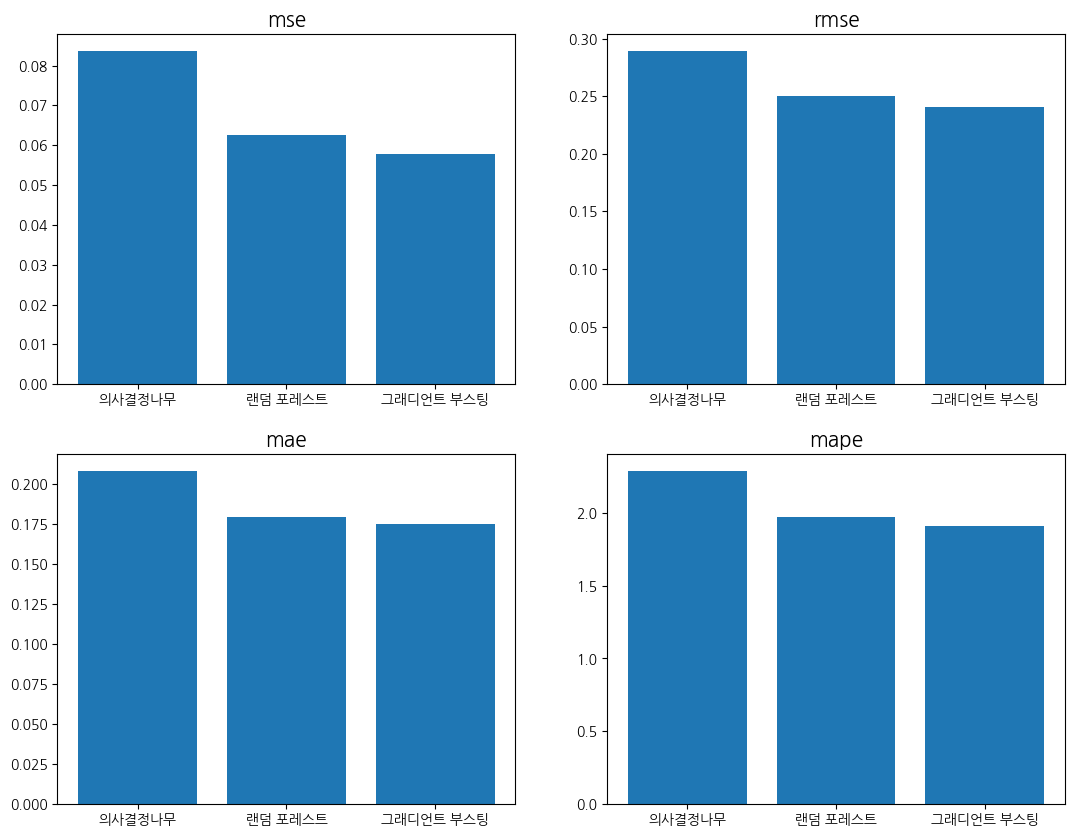

In [109]:
fig, ax = plt.subplots(2,2, figsize = (13, 10))

ax[0,0].bar(models, mse)
ax[0,0].set_title("mse").set_fontsize(15)

ax[0,1].bar(models, rmse)
ax[0,1].set_title("rmse").set_fontsize(15)

ax[1,0].bar(models, mae)
ax[1,0].set_title("mae").set_fontsize(15)

ax[1,1].bar(models, mape)
ax[1,1].set_title("mape").set_fontsize(15)

- 모델 평가지표 4가지 모두 GB 모델이 가장 우수한 성능을 보인다. 따라서 예측력이 가장 좋다고 판단되는 GB를 최종 모델로 선정하였다.
- GB :  train 0.930 / test 0.922